# Foreword
This is V2 of this sheet. The first one I froze a save of as I believe it had some problems with the methodology of my data pre-processing.
**BUT**, not to worry. This is V2, which is based on the same bones. So this should ideally fix some of the issues and get a better model.

# 0. Census Data Experiment
## Machine Learning and Data Science Practice
### By Rory Thomas
So this is basically me playing with this one question: What can you can guess from this data?

You can get the data from here: https://www.ons.gov.uk/census/maps/choropleth/, or in bulk (and a better format here) https://www.nomisweb.co.uk/sources/census_2021_bulk.

The Election data is available here:
- 2024: https://commonslibrary.parliament.uk/research-briefings/cbp-10009/.
- 2019: https://commonslibrary.parliament.uk/research-briefings/cbp-8749/.

Obviously, doesn't narrow down what I am actually talking about so let's be more specific about some of the questions:
- Could you estimate the number of LGBT people in an area?
- Could you estimate if the area provided is wealthy or not?
- Could you guess the average age of designated area?
- Could you guess the education level of an area?
- Could you identify areas that are likely to have a university?
- Could you guess how an area voted in the 2024 general election?

**"Could you guess how an area voted in the 2024 general election?"** is the most interesting question to be honest. Let's work with this.

# 1. Install the required packages and read in the data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
import os

In [4]:
current_dir = os.getcwd()
census_data_dir = (current_dir + '/DataSet/Census Data/')
election_data_dir = (current_dir + '/DataSet/Election Data/')
mapping_data_dir = (current_dir + '/DataSet/Mapping/')

In [5]:
# This is the random state variable that will be used throughout the code.
random_code = 42

Before I go any further, it is worth exploring what each dataset suffix refers to.
1. 'CTRY' refers to "Country". These are always "England and Wales", "England" and "Wales. This basically the highest level you can get (NI and Scotland handle their own censuses).
2. 'LSOA' refers to [unknown acronym]. These are basically fractions of districts, like a fraction of Roath, or Pontcanna.
3. 'LTLA' refers to [unknown acronym]. These are basically whole cities; think Newport, Cardiff, Swansea.
4. 'MSOA' refers to "Middle Layer Super Output Areas". These are districts of an area; think Cathays North, Cathays South, Roath and Pontcanna. 
5. 'OA' refers to "Output Areas". This is the most granular layer, containing sets of streets like "Coburn Street and Wyverne Street", and "Thesiger Street".
6. 'RGN' refers to "Regions". These are more arbitrary categories like South East, South West, London and North West.
7. 'UTLA' refers to "Local Area Districts (LAD)". This is basically Cardiff, Newport, Rhondda Cynon Taf, Bridgend, greater areas of a central place. 
8. 'PCON' refers to "Parliamentary Constituencies". This exactly what it sounds like.

Regarding the election data though, we have 1 problem. The census doesn't record these within electoral bounds. None of the above listed are anything to do with electoral stuff.
So we have a task to map one of these to the electoral map, somehow. We have some solutions:
1. We have the 2024 Westminster Electoral Constituencies to OA: https://geoportal.statistics.gov.uk/datasets/5968b5b2c0f14dd29ba277beaae6dec3_0/explore
2. We also have the 2024 PCON to MSOA: https://geoportal.statistics.gov.uk/datasets/098360c460dd41beacbdfad83bc4fea2_0/explore
3. We also have the 2024 PCON to LSOA: https://geoportal.statistics.gov.uk/datasets/0d62b50d90d14b8d8b2ccf9f770b5751_0/explore (which is near-enough the same granularity of OA, so I'm not sure what benefit it would add)
The clear solution is to build a mapping table.

One more thing. All the data headers are the first row for each CSV, so I'll need to extract the definitions from there and get whatever is usable.
*I did download all the data, which may not be useful for me to work. So I may have given myself a task to clean up a lot of it.*

In [6]:
df = pd.read_csv(os.path.join(census_data_dir, 'census2021-ts002-rgn.csv'))
df.head()

date                 geography geography code  \
0  2021                North East      E12000001   
1  2021                North West      E12000002   
2  2021  Yorkshire and The Humber      E12000003   
3  2021             East Midlands      E12000004   
4  2021             West Midlands      E12000005   

   Marital and civil partnership status: Total; measures: Value  \
0                                            2178960              
1                                            6025636              
2                                            4460298              
3                                            3998045              
4                                            4801329              

   Marital and civil partnership status: Never married and never registered a civil partnership; measures: Value  \
0                                             829791                                                               
1                                            2372877                                                               
2                                            1679861                                                               
3                                            1442049                                                               
4                                            1781208                                                               

   Marital and civil partnership status: Married or in a registered civil partnership; measures: Value  \
0                                             937083                                                     
1                                            2575107                                                     
2                                            1971162                                                     
3                                            1832929                                                     
4                                            2172973                                                     

   Marital and civil partnership status: Married or in a registered civil partnership: Married; measures: Value  \
0                                             933521                                                              
1                                            2565016                                                              
2                                            1962879                                                              
3                                            1825699                                                              
4                                            2164831                                                              

   Marital and civil partnership status: Married or in a registered civil partnership: Married: Opposite sex; measures: Value  \
0                                             928213                                                                            
1                                            2548818                                                                            
2                                            1951385                                                                            
3                                            1815824                                                                            
4                                            2153949                                                                            

   Marital and civil partnership status: Married or in a registered civil partnership: Married: Same sex; measures: Value  \
0                                               5308                                                                        
1                                              16198                                                                        
2                                              11494                                                            

## 1.1 Election Data
The election data, I'll keep as two separate tables for two separate elections. Makes it a bit easier for me when doing the analysis.

In [7]:
GE2019_df = pd.read_csv(os.path.join(election_data_dir, 'HOC-GE2019-results-by-constituency.csv'))
GE2019_df.dropna(axis=1,inplace=True)
GE2019_df.drop(columns=['ONS region ID','Region name','Country name','Constituency type','Member first name','Member surname','Member gender',"Result","Second party", "Majority","APNI", "UUP", "SDLP", "SF", "DUP", "SNP","Of which other winner"], inplace=True)
GE2019_df.rename(columns={'ONS ID':'PCON25CD','Constituency name':'PCON25NM','First party':'Elected','All other candidates':'Ind'}, inplace=True)

GE2024_df = pd.read_csv(os.path.join(election_data_dir, 'HOC-GE2024-results-by-constituency.csv'))
GE2024_df.dropna(axis=1,inplace=True)
GE2024_df.drop(columns=['ONS region ID','Region name','Country name','Constituency type','Member first name','Member surname','Member gender',"Result","Second party", "Majority","APNI", "UUP", "SDLP", "SF", "DUP", "SNP","Of which other winner"], inplace=True)
GE2024_df.rename(columns={'ONS ID':'PCON25CD','Constituency name':'PCON25NM', 'First party':'Elected','All other candidates':'Ind'}, inplace=True)
GE2024_df.head()

PCON25CD                            PCON25NM Elected  Electorate  \
0  W07000081                    Aberafan Maesteg     Lab       72580   
1  S14000060                      Aberdeen North     SNP       75925   
2  S14000061                      Aberdeen South     SNP       77328   
3  S14000062  Aberdeenshire North and Moray East     SNP       70058   
4  S14000063                  Airdrie and Shotts     Lab       70199   

   Valid votes  Invalid votes    Con    Lab    LD   RUK  Green    PC   Ind  
0        35755             79   2903  17838   916  7484   1094  4719   801  
1        42095            115   5881  12773  2583  3781   1275     0  1269  
2        46345            178  11300  11455  2921  3199   1609     0   648  
3        38188            170  12513   3876  2782  5562      0     0     0  
4        36666             95   1696  18871   725  2971      0     0  1079

Now I do think it's worth keeping the raw numbers but I want these in a bit better format of percentage of the votes. So I'm going to create two new data frames to change the numbers to percents.

In [8]:
GE2019_frac_df = GE2019_df.copy()
GE2019_frac_df.drop(columns=['Electorate','Valid votes', 'Invalid votes'], inplace=True)
GE2019_frac_df[GE2019_frac_df.columns[3:]] = GE2019_df[GE2019_df.columns[6:]].div(GE2019_df[GE2019_df.columns[6:]].sum(axis=1), axis=0)

GE2024_frac_df = GE2024_df.copy()
GE2024_frac_df.drop(columns=['Electorate','Valid votes', 'Invalid votes'], inplace=True)
GE2024_frac_df[GE2024_frac_df.columns[3:]] = GE2024_df[GE2024_df.columns[6:]].div(GE2024_df[GE2024_df.columns[6:]].sum(axis=1), axis=0)

GE2024_frac_df.head()

PCON25CD                            PCON25NM Elected       Con       Lab  \
0  W07000081                    Aberafan Maesteg     Lab  0.081191  0.498895   
1  S14000060                      Aberdeen North     SNP  0.213373  0.463428   
2  S14000061                      Aberdeen South     SNP  0.362971  0.367949   
3  S14000062  Aberdeenshire North and Moray East     SNP  0.505923  0.156714   
4  S14000063                  Airdrie and Shotts     Lab  0.066924  0.744653   

         LD       RUK     Green        PC       Ind  
0  0.025619  0.209313  0.030597  0.131982  0.022402  
1  0.093716  0.137182  0.046259  0.000000  0.046042  
2  0.093826  0.102756  0.051683  0.000000  0.020815  
3  0.112481  0.224882  0.000000  0.000000  0.000000  
4  0.028609  0.117236  0.000000  0.000000  0.042578

## 1.2 Mapping Data
Finally, let's get the mapping data and make one unified mapping data frame.
We'll preserve the names too because we can use this for our human readableness.

In [9]:
MSOA2021_to_PCON2024_df = pd.read_csv(os.path.join(mapping_data_dir, 'MSOA_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.csv'))
OA2021_to_PCON2024_df = pd.read_csv(os.path.join(mapping_data_dir, 'Output_area_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.csv'))
MSOA2021_to_PCON2024_df.dropna(axis=1, inplace=True)
OA2021_to_PCON2024_df.dropna(axis=1, inplace=True)

c:\Users\roryj\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
MSOA2021_to_PCON2024_df.head()

MSOA21CD      MSOA21NM   PCON25CD   PCON25NM    LAD21CD   LAD21NM  \
0  E02004807  Rushmoor 006  E14001063  Aldershot  E07000092  Rushmoor   
1  E02004804  Rushmoor 003  E14001063  Aldershot  E07000092  Rushmoor   
2  E02004813  Rushmoor 012  E14001063  Aldershot  E07000092  Rushmoor   
3  E02004812  Rushmoor 011  E14001063  Aldershot  E07000092  Rushmoor   
4  E02004805  Rushmoor 004  E14001063  Aldershot  E07000092  Rushmoor   

   ObjectId  
0         1  
1         2  
2         3  
3         4  
4         5

In [11]:
OA2021_to_PCON2024_df.head()

OA21CD   PCON25CD PCON25NM    LAD21CD               LAD21NM  ObjectId
0  E00000337  E14001073  Barking  E09000002  Barking and Dagenham         1
1  E00000338  E14001073  Barking  E09000002  Barking and Dagenham         2
2  E00000340  E14001073  Barking  E09000002  Barking and Dagenham         3
3  E00000341  E14001073  Barking  E09000002  Barking and Dagenham         4
4  E00000342  E14001073  Barking  E09000002  Barking and Dagenham         5

## 1.3 Census Data

In [12]:
csv_names = []
csv_names_oa = []
csv_names_msoa = []

set_names = []
set_names_oa = []
set_names_msoa = []

files = os.listdir(census_data_dir)

for file in files:
    if '.csv' in file:  # We only care about the CSVs
        csv_names.append(file)
        set_names.append(file[11:16])
        if '-msoa' in file:
            csv_names_msoa.append(file)
            set_names_msoa.append(file[11:16])
        elif '-oa' in file:
            csv_names_oa.append(file)
            set_names_oa.append(file[11:16])
        else:
            pass
# Summary stuff
print("There is a total of %d unique data sets" %(len(set(set_names))))
print("%d contain 'OA' in their geography" %(len(set(csv_names_oa))))
print("%d contain 'MSOA' in their geography" %(len(set(csv_names_msoa))))

# Get the missing data sets
missing_oa = set(set_names) - set(set_names_oa)
missing_msoa = set(set_names) - set(set_names_msoa)
missing_both = missing_msoa & missing_oa
print("The missing data sets for the OA areas are: " + str(missing_oa))
print("The missing data sets for the MSOA areas are: " + str(missing_msoa))
print("The data sets missing both the OA and MSOA areas are: " + str(missing_both))



There is a total of 60 unique data sets
46 contain 'OA' in their geography
56 contain 'MSOA' in their geography
The missing data sets for the OA areas are: {'ts078', 'ts048', 'ts070', 'ts012', 'ts024', 'ts022', 'ts064', 'ts028', 'ts060', 'ts071', 'ts031', 'ts076', 'ts047', 'ts077'}
The missing data sets for the MSOA areas are: {'ts076', 'ts024', 'ts012', 'ts070'}
The data sets missing both the OA and MSOA areas are: {'ts070', 'ts076', 'ts024', 'ts012'}


Kind of annoying we have some useless sets then. But it is what it is.
Looking manually the following are unusable:
- TS012: "Country of birth (detailed)" which goes into potential location of their birth in more detail (like "Spain (including Canary Islands)" or "Antarctica and Oceania: Other Oceania and Antarctica") but we have "Country of Birth" (TS004) which just says "Born in the UK" or "Born outside the UK", so may be better this.
*Sad it groups Antarctica with Oceania, it would be interesting to see how many people declared they were born in Antarctica.*
- TS024: "Main language (detailed)" which might have had an effect but we have others detailling proficiency in English (TS029) and if the household has multiple main languages (TS026) so might be inconsequential.
- TS070: "Gender identity (detailed)" but we have the non-detailed variant of TS078 which the only seeming difference is that Non-Binary is encompassed in "Other Gender Identities" in 078.
- TS076: "Welsh language skills (speaking) by single year of age" but this made redundant by TS032 to TS036 which all cover welsh language abilities.

What we can see though is that MSOA has all the useful codes, so this is what we should use as our list. I'll do most of my analysis with MSOA anyways, as I think the OA will be too granular as well thinking of it, and I may overfit.

In [13]:
#filtered_files = [file for file in files if any(name in file for name in set_names_msoa) and ('-oa' in file or '-msoa' in file)]
filtered_files_msoa = [file for file in files if any(name in file for name in set_names_msoa) and '-msoa' in file]
filtered_files_oa = [file for file in files if any(name in file for name in set_names_msoa) and '-oa' in file]
print(filtered_files_msoa)
print(filtered_files_oa)

"""# Let's put them into a dictionary to reference
filtered_dict = {}
for file in filtered_files:
    dataset_name = file[11:16]
    if dataset_name not in filtered_dict:
        filtered_dict[dataset_name] = []
    filtered_dict[dataset_name].append(file)

print(filtered_dict)"""

['census2021-ts001-msoa.csv', 'census2021-ts002-msoa..csv', 'census2021-ts003-msoa.csv', 'census2021-ts004-msoa.csv', 'census2021-ts006-msoa.csv', 'census2021-ts010-msoa.csv', 'census2021-ts011-msoa.csv', 'census2021-ts017-msoa.csv', 'census2021-ts019-msoa.csv', 'census2021-ts021-msoa.csv', 'census2021-ts022-msoa.csv', 'census2021-ts023-msoa.csv', 'census2021-ts025-msoa.csv', 'census2021-ts026-msoa.csv', 'census2021-ts027-msoa.csv', 'census2021-ts028-msoa.csv', 'census2021-ts029-msoa.csv', 'census2021-ts030-msoa.csv', 'census2021-ts031-msoa.csv', 'census2021-ts032-msoa.csv', 'census2021-ts033-msoa.csv', 'census2021-ts034-msoa.csv', 'census2021-ts035-msoa.csv', 'census2021-ts036-msoa.csv', 'census2021-ts037-msoa.csv', 'census2021-ts038-msoa.csv', 'census2021-ts039-msoa.csv', 'census2021-ts040-msoa.csv', 'census2021-ts041-msoa.csv', 'census2021-ts044-msoa.csv', 'census2021-ts045-msoa.csv', 'census2021-ts046-msoa.csv', 'census2021-ts047-msoa.csv', 'census2021-ts048-msoa.csv', 'census2021-

"# Let's put them into a dictionary to reference\nfiltered_dict = {}\nfor file in filtered_files:\n    dataset_name = file[11:16]\n    if dataset_name not in filtered_dict:\n        filtered_dict[dataset_name] = []\n    filtered_dict[dataset_name].append(file)\n\nprint(filtered_dict)"

We'll group these then into a few different categories. The idea is that rather than one big model (as we attempted last time) we can have a bunch of 'areas of concern' that we can group our census data into. We can then try and use these like a voting system where each model then votes on how they think the constituency went.
We'll also drop some of the verbose models which just have too much data for us to use.

Our groups will be:
- National Population [Total Categories = 8]
  - TS001: Number of usual residents in households and communal establishments	
  - TS002: Legal partnership status
  - TS004: Country of Birth
  - TS010: Living Arrangements
  - TS019: Migrant Indicator
  - TS025: Household language
  - TS029: Proficiency in English
  - TS032: Welsh language skills (detailed)
- Sexuality, Personal Identity, Relationships and Health (SPIRH) [Total Categories = 9]
  - TS008: Sex
  - TS021: Ethnic group
  - TS027: National identity - UK
  - TS030: Religion
  - TS037: General Health
  - TS038: Disability
  - TS075: Multi Religion Households
  - TS077: Sexual Orientation
  - TS078: Gender Identity 
- Housing: [Total Categories = 11]
  - TS003: Household composition
  - TS017: Household Size
  - TS044: Accomadation Type
  - TS045: Car or Van availability
  - TS046: Central Heating availability
  - TS050: Number of Bedrooms
  - TS051: Number of Rooms
  - TS052: Occupancy rating for Bedrooms
  - TS053: Occupancy rating for Rooms
  - TS054: Tenure
  - TS056: Second address indicator
- Education, Econony and Occupation (EOO) [Total Categories = 10]
  - TS011: Households by deprivation dimensions	
  - TS039: Provision of Unpaid Care
  - TS059: Hours worked 
  - TS060: Industry
  - TS061: Method of travel to work 
  - TS062: NS-SeC
  - TS063: Occupation
  - TS066: Economic activity status
  - TS067: Highest level of qualification
  - TS068: Schoolchildren and full-time students
  - TS071: Previously served in the UK armed forces 

Unclaimed:
- TS005: Passports Held > May not provide enough new informatuon that TS004 wouldn't
- TS012: Country of birth (detailed) > Too verbose
- TS013: Passports held (detailed) > Too verbose
- TS015: Year of arrival in UK > Again another migrant indicator 	
- TS016: Length of residence > Again another migrant indicator 	
- TS018: Age of arrival in the UK > Again another migrant indicator 	
- TS020: Number of non-UK short-term residents by sex > Maybe helpful but I doubt this had much impact on the election
- TS021: Ethnic group (detailed) >  Too verbose
- TS028: National identity (detailed) >  Too verbose
- TS031: Religion (detailed) >  Too verbose
- TS033: Welsh language skills (speaking) >  Redundant by TS032
- TS034: Welsh language skills (writing) >  Redundant by TS032
- TS035: Welsh language skills (reading) >  Redundant by TS032
- TS036: Welsh language skills (understanding) >  Redundant by TS032
- TS076: Welsh language skills (speaking) by single year of age >  Redundant by TS032
- TS041: Number of households > Basically a metric of area size. Not helpful
- TS055: Purpose of Second Address > Deemed too specific for such a potential small group of the population
- TS058: Distance travelled to work > Too specific 
- TS065: Unemployment history > Not specific enough, and made redundant by TS066
- TS070: Gender identity (detailed) > No data available in MSOA or OA, plus only distinction is the further addition of 'Non-Binary' which may have little additional benefit compared to just 'Other genders'
- TS072: Number of people in household who have previously served in UK armed forces > Too similar to TS071
- TS073: Population who have previously served in UK armed forces in communal establishments and in households > Too similar to TS071
- TS074: Household Reference Person indicator of previous service in UK armed forces > Too similar to TS071
- TS075: Multi religion household > Too specific 
- TS079: Sexual orientation (detailed) > No data available in MSOA or OA, 

In [14]:
natpop_census_categories = ["TS001", "TS002", "TS004", "TS010", "TS019", "TS025", "TS029", "TS032"]
natpop_census_categories = [element.lower() for element in natpop_census_categories]
spirh_census_categories = ["TS008","TS021","TS027","TS030","TS037","TS038","TS075","TS077","TS078"]
spirh_census_categories = [element.lower() for element in spirh_census_categories]
housing_census_categories = ["TS003","TS017","TS044","TS045","TS046","TS050","TS051","TS052","TS053","TS054","TS056"]
housing_census_categories = [element.lower() for element in housing_census_categories]
eeo_census_categories = ["TS011","TS039","TS059","TS060","TS061","TS062","TS063","TS066,","TS067","TS068"," TS071"]
eeo_census_categories = [element.lower() for element in eeo_census_categories]

We'll also need to do a bit of *finessing* each data set, as some have annoying things like totals....

In [15]:
census_natpop_pcon_df = None
census_spirh_pcon_df = None
census_housing_pcon_df = None
census_eeo_pcon_df = None
for file in filtered_files_msoa: # Loop through our files
    name = file[11:16]
    
    placeholder_df = pd.read_csv(os.path.join(census_data_dir, file))
    placeholder_df.drop(columns=['date'], inplace=True)
    placeholder_df.rename(columns={'geography code': 'MSOA21CD', 'geography': "MSOA21NM"}, inplace=True)
    columns_to_drop = [col for col in placeholder_df.columns if 'total' in col.lower()]
    placeholder_df.drop(columns=columns_to_drop, inplace=True)
    
    placeholder_df = placeholder_df.merge(MSOA2021_to_PCON2024_df, on='MSOA21CD', how='left', copy=False)
    placeholder_df.drop(columns=['MSOA21NM_x','MSOA21NM_y','MSOA21CD','LAD21CD','LAD21NM','ObjectId','PCON25NM'], inplace=True)
    # Just move geography columns to 'front' of the dataframe
    placeholder_df = placeholder_df[ ['PCON25CD'] + [ col for col in placeholder_df.columns if col != 'PCON25CD' ] ]
    # Now we want to put these so that one row = one constituency
    placeholder_df = placeholder_df.groupby(['PCON25CD'], as_index=False).aggregate('sum').reindex(columns=placeholder_df.columns)

    placeholder_df_numeric = placeholder_df.select_dtypes(include=[np.number])
    placeholder_df[placeholder_df_numeric.columns] = placeholder_df_numeric.div(placeholder_df.sum(axis=1), axis=0)
    
    if name in natpop_census_categories:
        if census_natpop_pcon_df is None:
            census_natpop_pcon_df = placeholder_df
        else:
            census_natpop_pcon_df = census_natpop_pcon_df.merge(placeholder_df, on='PCON25CD', how='left', copy=False)
    elif name in spirh_census_categories:
        if census_spirh_pcon_df is None:
            census_spirh_pcon_df = placeholder_df
        else:
            census_spirh_pcon_df = census_spirh_pcon_df.merge(placeholder_df, on='PCON25CD', how='left', copy=False)
    elif name in housing_census_categories:
        if census_housing_pcon_df is None:
            census_housing_pcon_df = placeholder_df
        else:
            census_housing_pcon_df = census_housing_pcon_df.merge(placeholder_df, on='PCON25CD', how='left', copy=False)
    elif name in eeo_census_categories:
        if census_eeo_pcon_df is None:
            census_eeo_pcon_df = placeholder_df
        else:
            census_eeo_pcon_df = census_eeo_pcon_df.merge(placeholder_df, on='PCON25CD', how='left', copy=False)
    else:
        print("Uncategorised: " + str(name))

print("Total number of constituencies in set: %d" %census_eeo_pcon_df.shape[0])


Uncategorised: ts006
Uncategorised: ts022
Uncategorised: ts023
Uncategorised: ts026
Uncategorised: ts028
Uncategorised: ts031
Uncategorised: ts033
Uncategorised: ts034
Uncategorised: ts035
Uncategorised: ts036
Uncategorised: ts040
Uncategorised: ts041
Uncategorised: ts047
Uncategorised: ts048
Uncategorised: ts055
Uncategorised: ts058
Uncategorised: ts064
Uncategorised: ts065
Uncategorised: ts066
Uncategorised: ts071
Total number of constituencies in set: 575


Wikipedia: https://en.wikipedia.org/wiki/Constituencies_of_the_Parliament_of_the_United_Kingdom

"As of the 2024 election there are 543 constituencies in England, 32 in Wales, 57 in Scotland and 18 in Northern Ireland." Meaning there are supposed 575 constituencies in our data set

In [16]:
print("NatPop: Shape of the final dataframe: " + str(census_natpop_pcon_df.shape))
print("SPIRH: Shape of the final dataframe: " + str(census_spirh_pcon_df.shape))
print("Housing: Shape of the final dataframe: " + str(census_housing_pcon_df.shape))
print("EEO: Shape of the final dataframe: " + str(census_eeo_pcon_df.shape))

NatPop: Shape of the final dataframe: (575, 71)
SPIRH: Shape of the final dataframe: (575, 81)
Housing: Shape of the final dataframe: (575, 93)
EEO: Shape of the final dataframe: (575, 163)


In [17]:
if len(census_natpop_pcon_df.columns) == len(set(census_natpop_pcon_df.columns)):
    print("NatPop: No duplicates")
else:
    print("NatPop: Duplicates found")
    
if len(census_spirh_pcon_df.columns) == len(set(census_spirh_pcon_df.columns)):
    print("SPIRH: No duplicates")
else:
    print("SPIRH: Duplicates found")
    
if len(census_housing_pcon_df.columns) == len(set(census_housing_pcon_df.columns)):
    print("Housing: No duplicates")
else:
    print("Housing: Duplicates found")
    
if len(census_eeo_pcon_df.columns) == len(set(census_eeo_pcon_df.columns)):
    print("EEO: No duplicates")
else:
    print("EEO: Duplicates found")

NatPop: No duplicates
SPIRH: No duplicates
Housing: No duplicates
EEO: No duplicates


As we can see, we can see all the missing ones are the Welsh abilities. Which makes sense as looking at the census, it is only Wales that records Welsh ability. England doesn't record this.
It's not the best, but I will put '0' for the entirety of England.

In [18]:
census_natpop_pcon_df.fillna(0, inplace=True)

if len(census_natpop_pcon_df.isna().any()[lambda x: x]) == 0:
    print("NatPop: No missing values")
else:
    print("NatPop: Missing values found")
    print(census_natpop_pcon_df.isna().any()[lambda x: x])
    
if len(census_spirh_pcon_df.isna().any()[lambda x: x]) == 0:
    print("SPIRH: No missing values")
else:
    print("SPIRH: Missing values found")
    print(census_spirh_pcon_df.isna().any()[lambda x: x])

if len(census_housing_pcon_df.isna().any()[lambda x: x]) == 0:
    print("Housing: No missing values")
else:
    print("Housing: Missing values found")
    print(census_housing_pcon_df.isna().any()[lambda x: x])

if len(census_eeo_pcon_df.isna().any()[lambda x: x]) == 0:
    print("EEO: No missing values")
else:
    print("EEO: Missing values found")
    print(census_eeo_pcon_df.isna().any()[lambda x: x])

NatPop: No missing values
SPIRH: No missing values
Housing: No missing values
EEO: No missing values


## 1.5 Joined Election and Census Data
Now let's put the election and census data together.

In [19]:
census_natpop_GE2024_df = census_natpop_pcon_df.merge(GE2024_frac_df, on='PCON25CD', how='inner', copy=False)
census_spirh_GE2024_df = census_spirh_pcon_df.merge(GE2024_frac_df, on='PCON25CD', how='inner', copy=False)
census_housing_GE2024_df = census_housing_pcon_df.merge(GE2024_frac_df, on='PCON25CD', how='inner', copy=False)
census_eeo_GE2024_df = census_eeo_pcon_df.merge(GE2024_frac_df, on='PCON25CD', how='inner', copy=False)
census_eeo_GE2024_df.head()

PCON25CD  \
0  E14001063   
1  E14001064   
2  E14001065   
3  E14001066   
4  E14001067   

   Household deprivation: Household is not deprived in any dimension; measures: Value  \
0                                           0.517207                                    
1                                           0.464069                                    
2                                           0.591750                                    
3                                           0.465690                                    
4                                           0.560200                                    

   Household deprivation: Household is deprived in one dimension; measures: Value  \
0                                           0.328354                                
1                                           0.344781                                
2                                           0.292319                                
3                                           0.342278                                
4                                           0.325507                                

   Household deprivation: Household is deprived in two dimensions; measures: Value  \
0                                           0.123547                                 
1                                           0.155131                                 
2                                           0.096224                                 
3                                           0.151346                                 
4                                           0.096872                                 

   Household deprivation: Household is deprived in three dimensions; measures: Value  \
0                                           0.028961                                   
1                                           0.034793                                   
2                                           0.018919                                   
3                                           0.039141                                   
4                                           0.016380                                   

   Household deprivation: Household is deprived in four dimensions; measures: Value  \
0                                           0.001931                                  
1                                           0.001226                                  
2                                           0.000787                                  
3                                           0.001544                                  
4                                           0.001042                                  

   Provision of unpaid care: Provides no unpaid care  \
0                                           0.880721   
1                                           0.831393   
2                                           0.865476   
3                                           0.832587   
4                                           0.856405   

   Provision of unpaid care: Provides 19 hours or less unpaid care a week  \
0                                           0.035925                        
1                                           0.047667                        
2                                           0.044662                        
3                                           0.048614                        
4                                           0.048396                        

   Provision of unpaid care: Provides 9 hours or less unpaid care a week  \
0                                           0.027112                       
1                                           0.034214                       
2                                           0.033660                       
3                                           0.035082                       
4                                           0.037524                       

   Provision of unpaid care: Provid

In [20]:
census_eeo_GE2024_df.head()

PCON25CD  \
0  E14001063   
1  E14001064   
2  E14001065   
3  E14001066   
4  E14001067   

   Household deprivation: Household is not deprived in any dimension; measures: Value  \
0                                           0.517207                                    
1                                           0.464069                                    
2                                           0.591750                                    
3                                           0.465690                                    
4                                           0.560200                                    

   Household deprivation: Household is deprived in one dimension; measures: Value  \
0                                           0.328354                                
1                                           0.344781                                
2                                           0.292319                                
3                                           0.342278                                
4                                           0.325507                                

   Household deprivation: Household is deprived in two dimensions; measures: Value  \
0                                           0.123547                                 
1                                           0.155131                                 
2                                           0.096224                                 
3                                           0.151346                                 
4                                           0.096872                                 

   Household deprivation: Household is deprived in three dimensions; measures: Value  \
0                                           0.028961                                   
1                                           0.034793                                   
2                                           0.018919                                   
3                                           0.039141                                   
4                                           0.016380                                   

   Household deprivation: Household is deprived in four dimensions; measures: Value  \
0                                           0.001931                                  
1                                           0.001226                                  
2                                           0.000787                                  
3                                           0.001544                                  
4                                           0.001042                                  

   Provision of unpaid care: Provides no unpaid care  \
0                                           0.880721   
1                                           0.831393   
2                                           0.865476   
3                                           0.832587   
4                                           0.856405   

   Provision of unpaid care: Provides 19 hours or less unpaid care a week  \
0                                           0.035925                        
1                                           0.047667                        
2                                           0.044662                        
3                                           0.048614                        
4                                           0.048396                        

   Provision of unpaid care: Provides 9 hours or less unpaid care a week  \
0                                           0.027112                       
1                                           0.034214                       
2                                           0.033660                       
3                                           0.035082                       
4                                           0.037524                       

   Provision of unpaid care: Provid

# 2. See the data and make some plots.
Now lets see if we can make out anything interesting from this information here. Because we have a lot of stuff to look at in this data but we need to make sure we make the data usable.

## 2.1 Correlation Matrices

In [21]:
census_natpop_GE2024_df_numeric = census_natpop_GE2024_df.select_dtypes(include=['int64', 'float64'])
census_housing_GE2024_df_numeric = census_housing_GE2024_df.select_dtypes(include=['int64', 'float64'])
census_eeo_GE2024_df_numeric = census_eeo_GE2024_df.select_dtypes(include=['int64', 'float64'])
census_spirh_GE2024_df_numeric = census_spirh_GE2024_df.select_dtypes(include=['int64', 'float64'])
corr_natpop = census_natpop_GE2024_df_numeric.corr()
corr_housing = census_housing_GE2024_df_numeric.corr()
corr_eeo = census_eeo_GE2024_df_numeric.corr()
corr_spirh = census_spirh_GE2024_df_numeric.corr()

This is a cool plot but completely unusable for us to see anything with, we'll need to filter this down a bit.

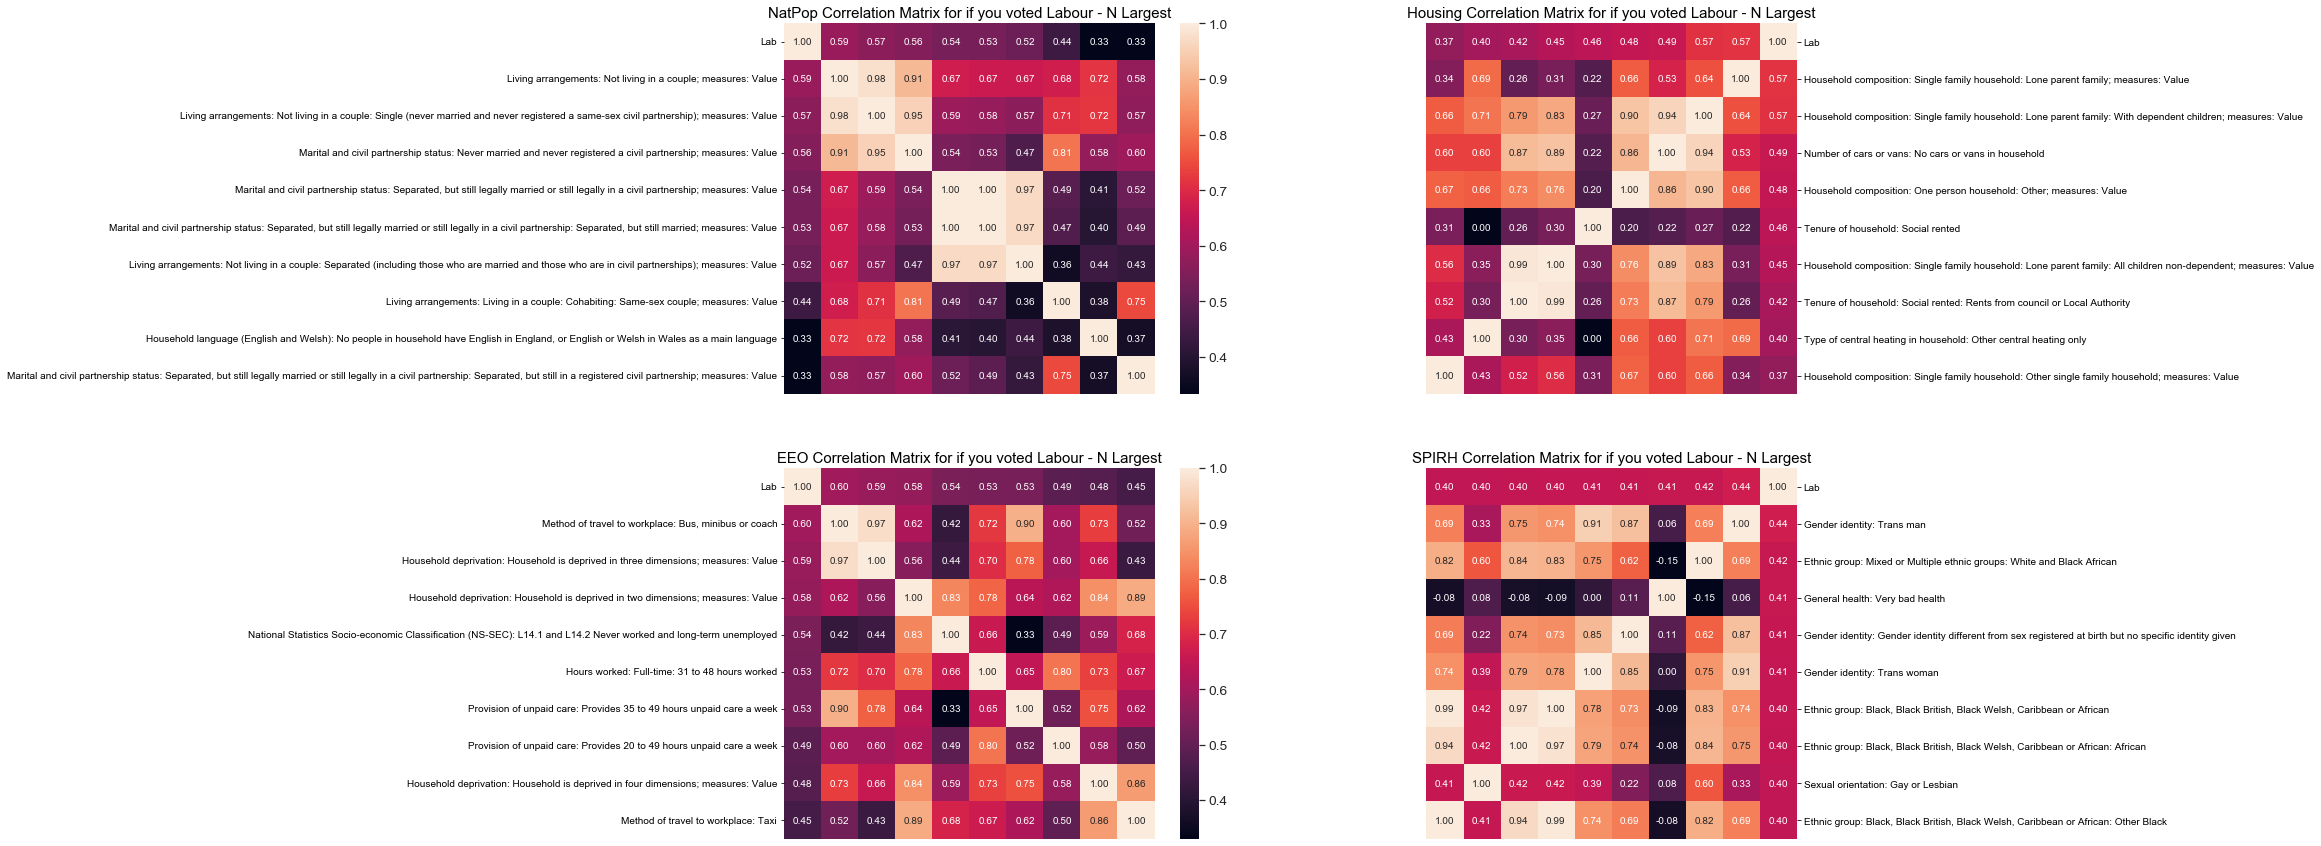

In [22]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'Lab')['Lab'].index
cols_eeo = corr_eeo.nlargest(k, 'Lab')['Lab'].index
cols_housing = corr_housing.nlargest(k, 'Lab')['Lab'].index
cols_spirh = corr_spirh.nlargest(k, 'Lab')['Lab'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Labour - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Labour - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Labour - N Largest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Labour - N Largest')

plt.tight_layout
plt.show()

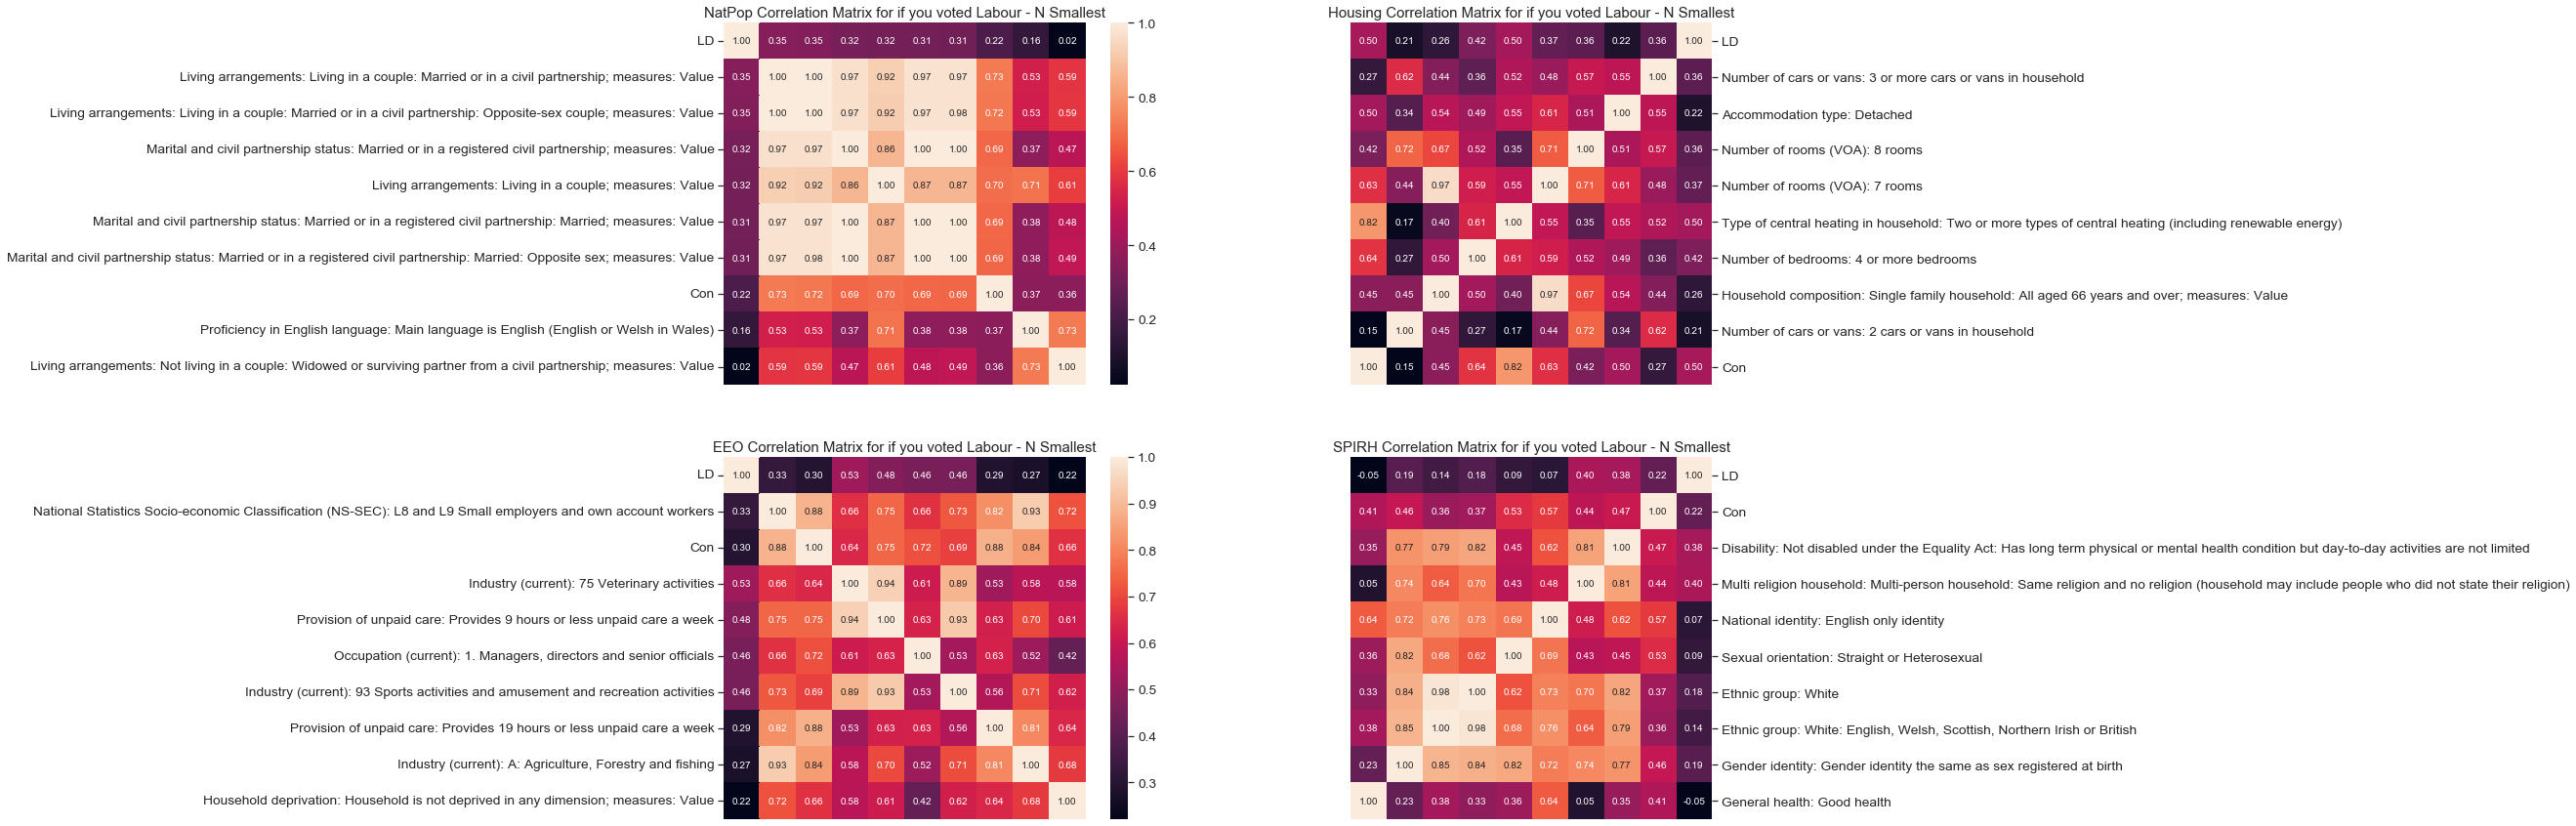

In [23]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'Lab')['Lab'].index
cols_eeo = corr_eeo.nsmallest(k, 'Lab')['Lab'].index
cols_housing = corr_housing.nsmallest(k, 'Lab')['Lab'].index
cols_spirh = corr_spirh.nsmallest(k, 'Lab')['Lab'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Labour - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Labour - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Labour - N Smallest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Labour - N Smallest')

plt.tight_layout
plt.show()

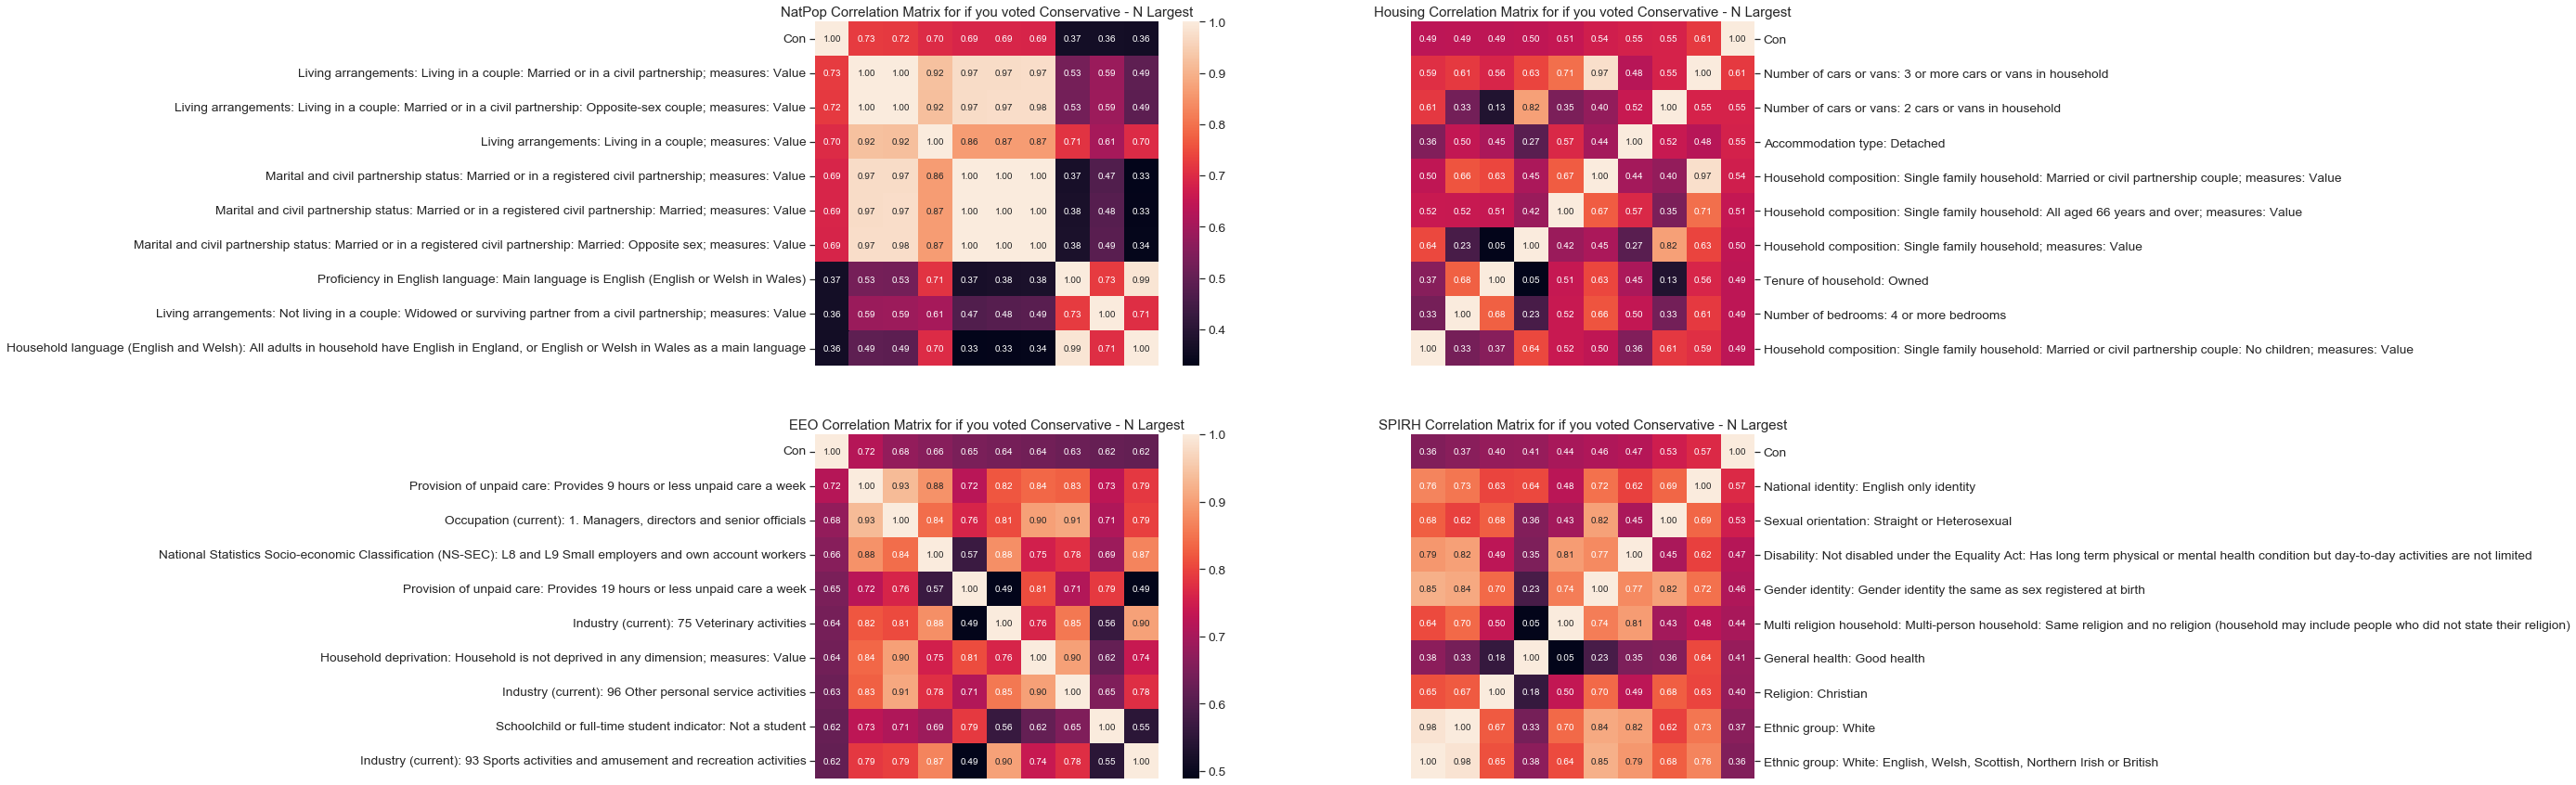

In [24]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'Con')['Con'].index
cols_eeo = corr_eeo.nlargest(k, 'Con')['Con'].index
cols_housing = corr_housing.nlargest(k, 'Con')['Con'].index
cols_spirh = corr_spirh.nlargest(k, 'Con')['Con'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Conservative - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Conservative - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Conservative - N Largest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Conservative - N Largest')

plt.tight_layout
plt.show()

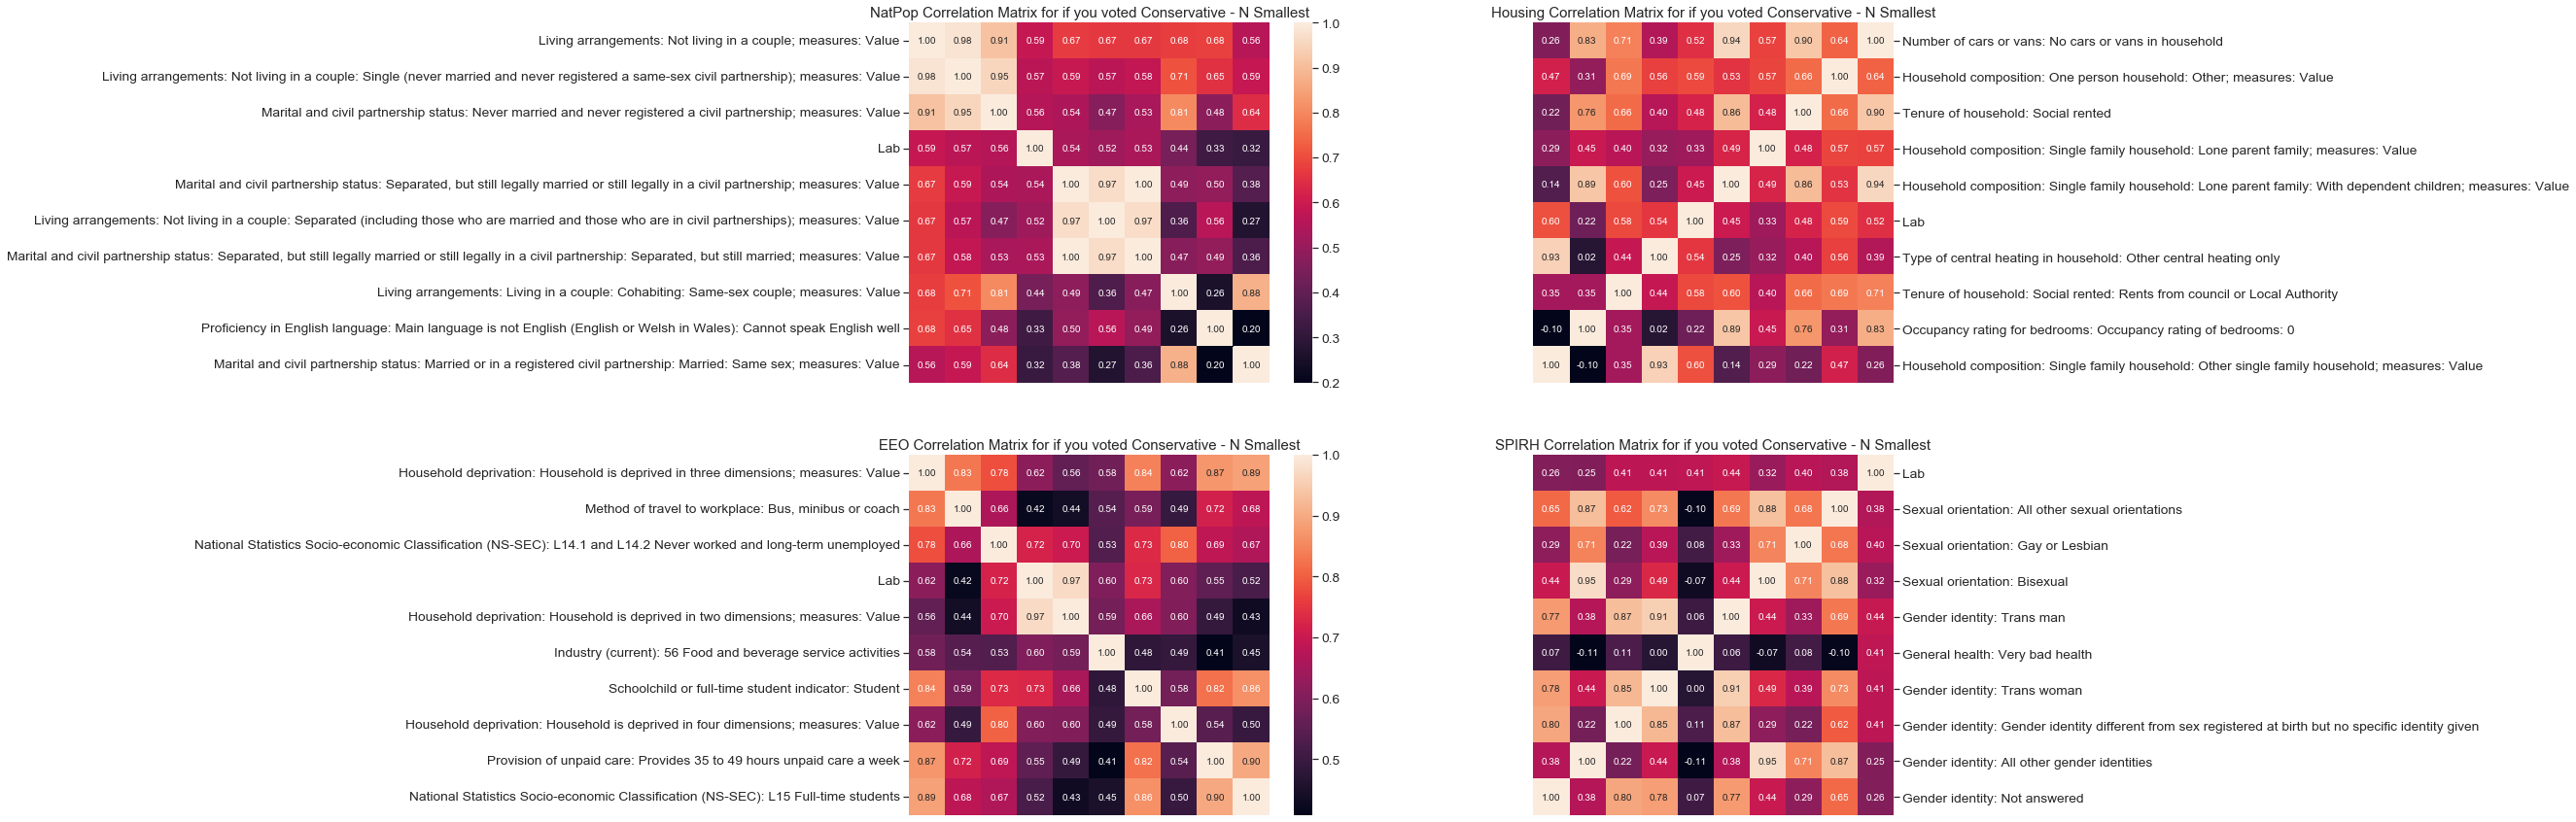

In [25]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'Con')['Con'].index
cols_eeo = corr_eeo.nsmallest(k, 'Con')['Con'].index
cols_housing = corr_housing.nsmallest(k, 'Con')['Con'].index
cols_spirh = corr_spirh.nsmallest(k, 'Con')['Con'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Conservative - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Conservative - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Conservative - N Smallest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Conservative - N Smallest')

plt.tight_layout
plt.show()

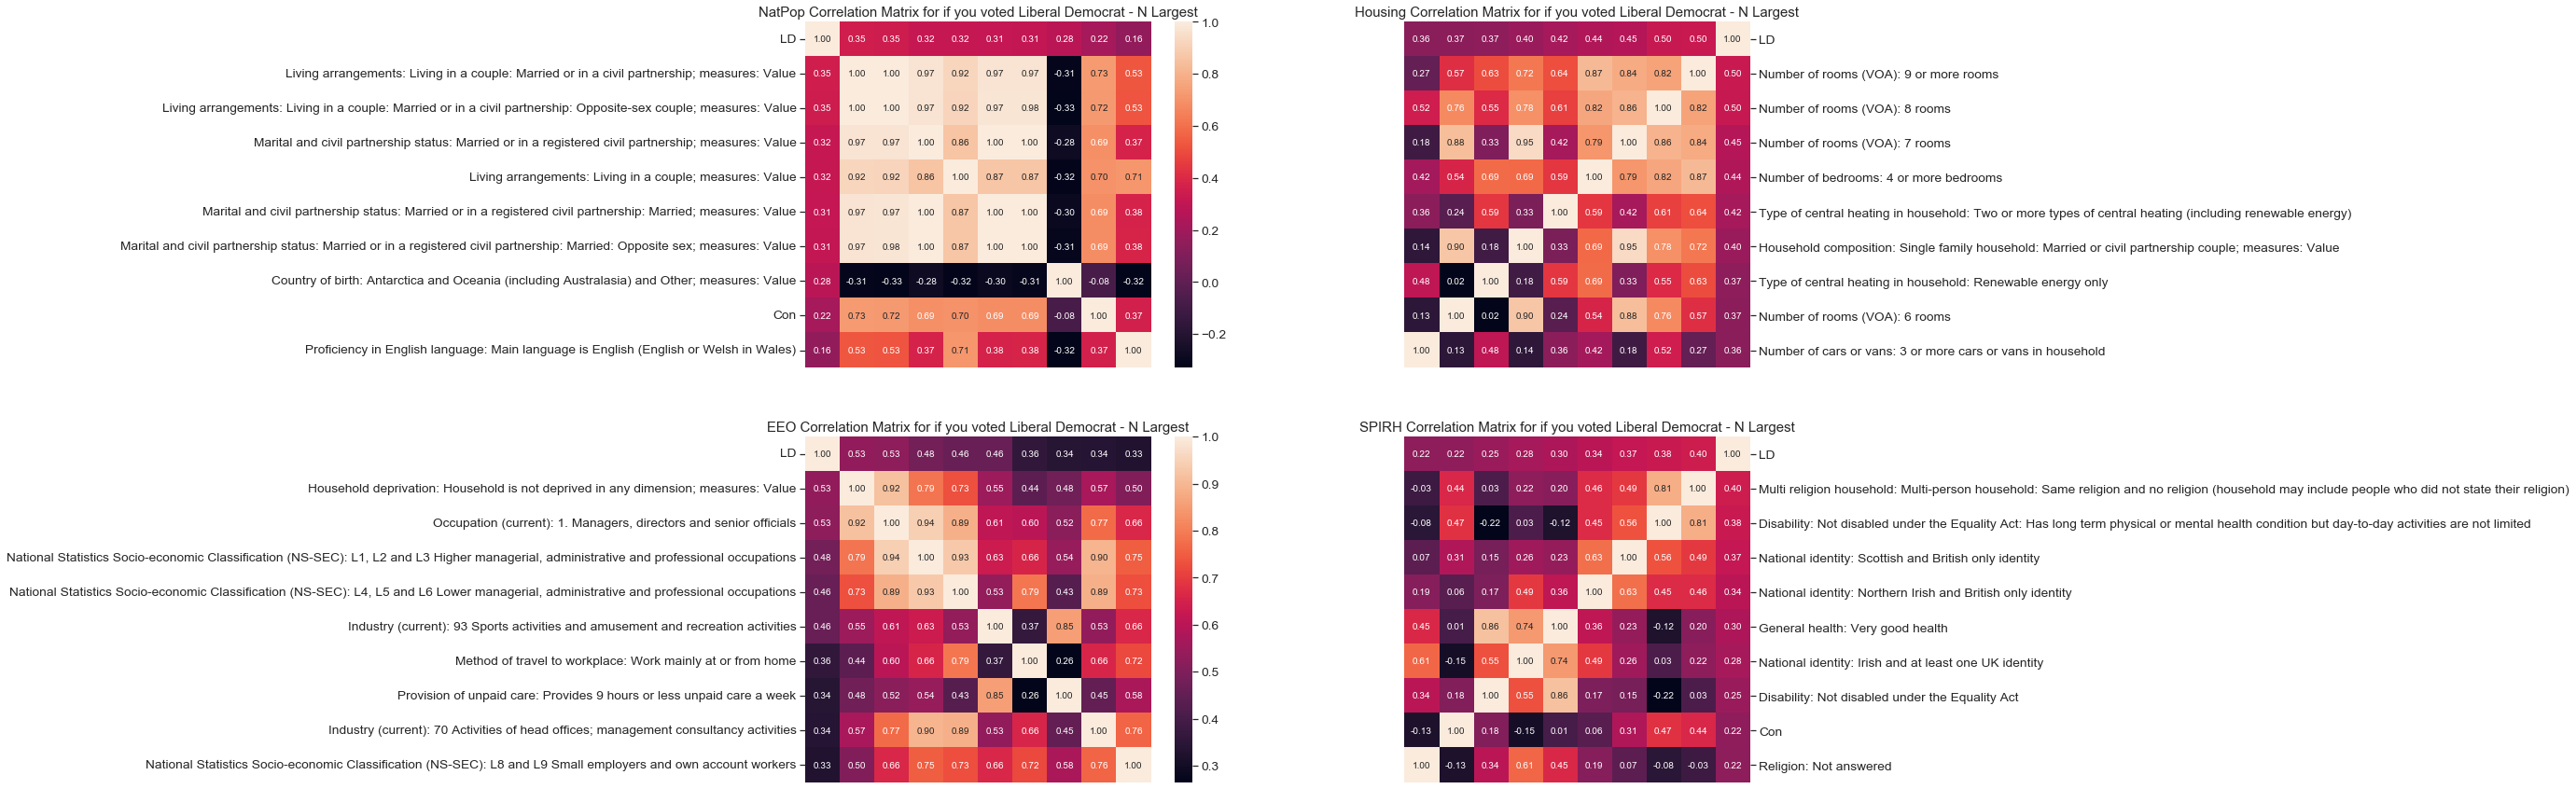

In [26]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'LD')['LD'].index
cols_eeo = corr_eeo.nlargest(k, 'LD')['LD'].index
cols_housing = corr_housing.nlargest(k, 'LD')['LD'].index
cols_spirh = corr_spirh.nlargest(k, 'LD')['LD'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Liberal Democrat - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Liberal Democrat - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Liberal Democrat - N Largest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Liberal Democrat - N Largest')

plt.tight_layout
plt.show()

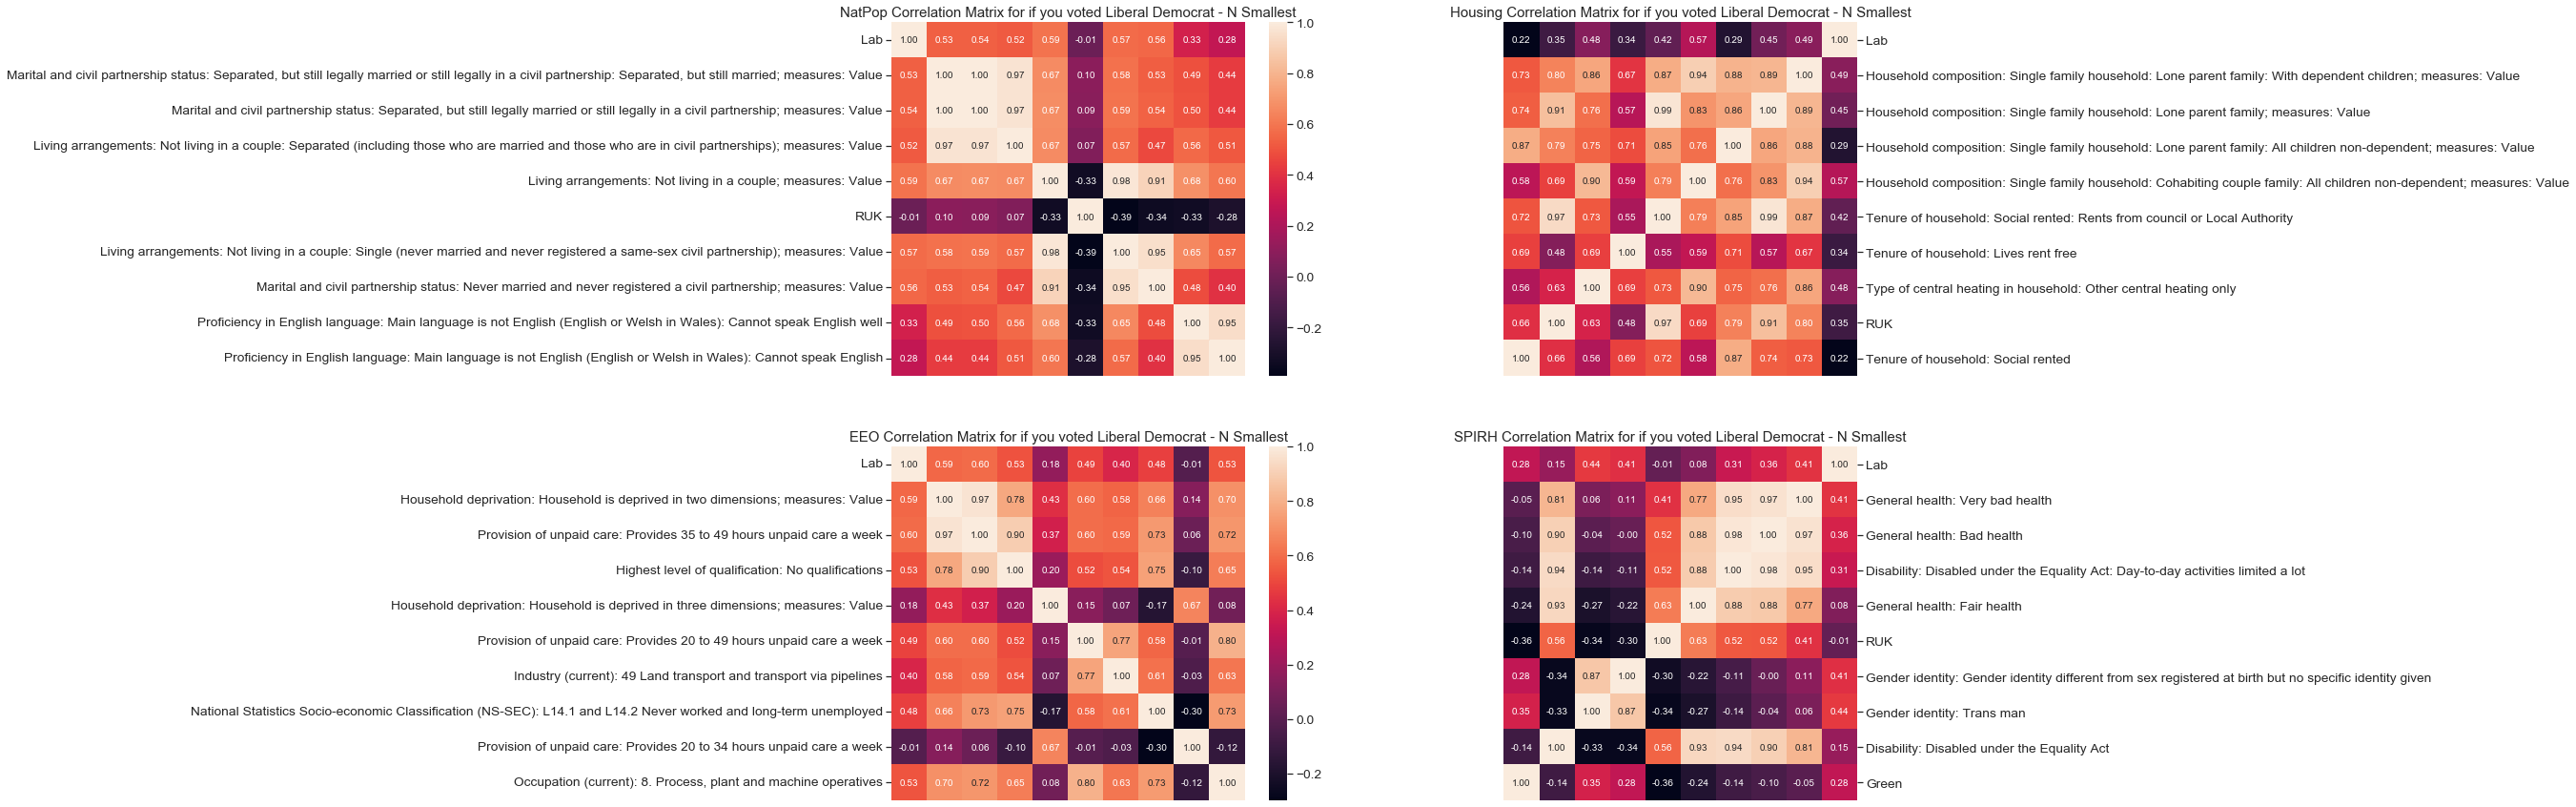

In [27]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'LD')['LD'].index
cols_eeo = corr_eeo.nsmallest(k, 'LD')['LD'].index
cols_housing = corr_housing.nsmallest(k, 'LD')['LD'].index
cols_spirh = corr_spirh.nsmallest(k, 'LD')['LD'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Liberal Democrat - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Liberal Democrat - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Liberal Democrat - N Smallest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Liberal Democrat - N Smallest')

plt.tight_layout
plt.show()

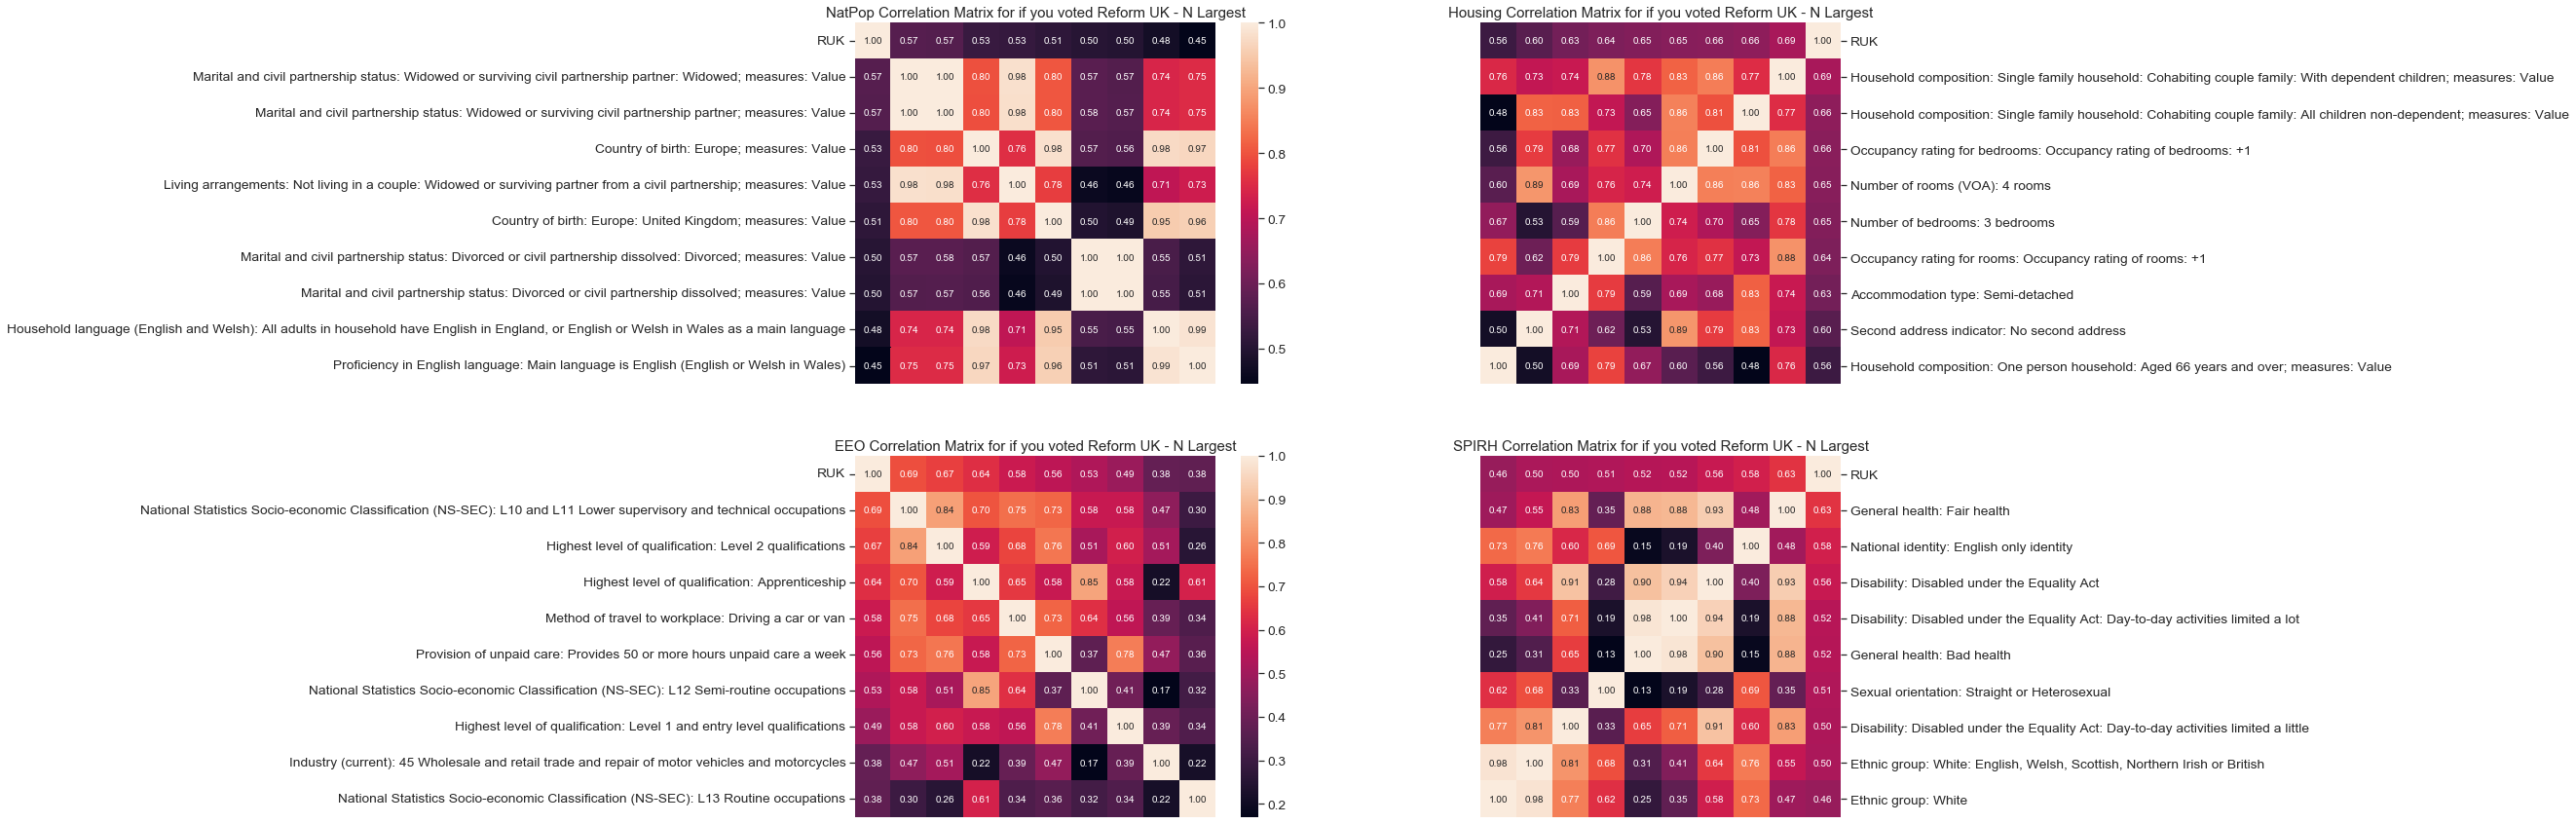

In [28]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'RUK')['RUK'].index
cols_eeo = corr_eeo.nlargest(k, 'RUK')['RUK'].index
cols_housing = corr_housing.nlargest(k, 'RUK')['RUK'].index
cols_spirh = corr_spirh.nlargest(k, 'RUK')['RUK'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Reform UK - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Reform UK - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Reform UK - N Largest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Reform UK - N Largest')

plt.tight_layout
plt.show()

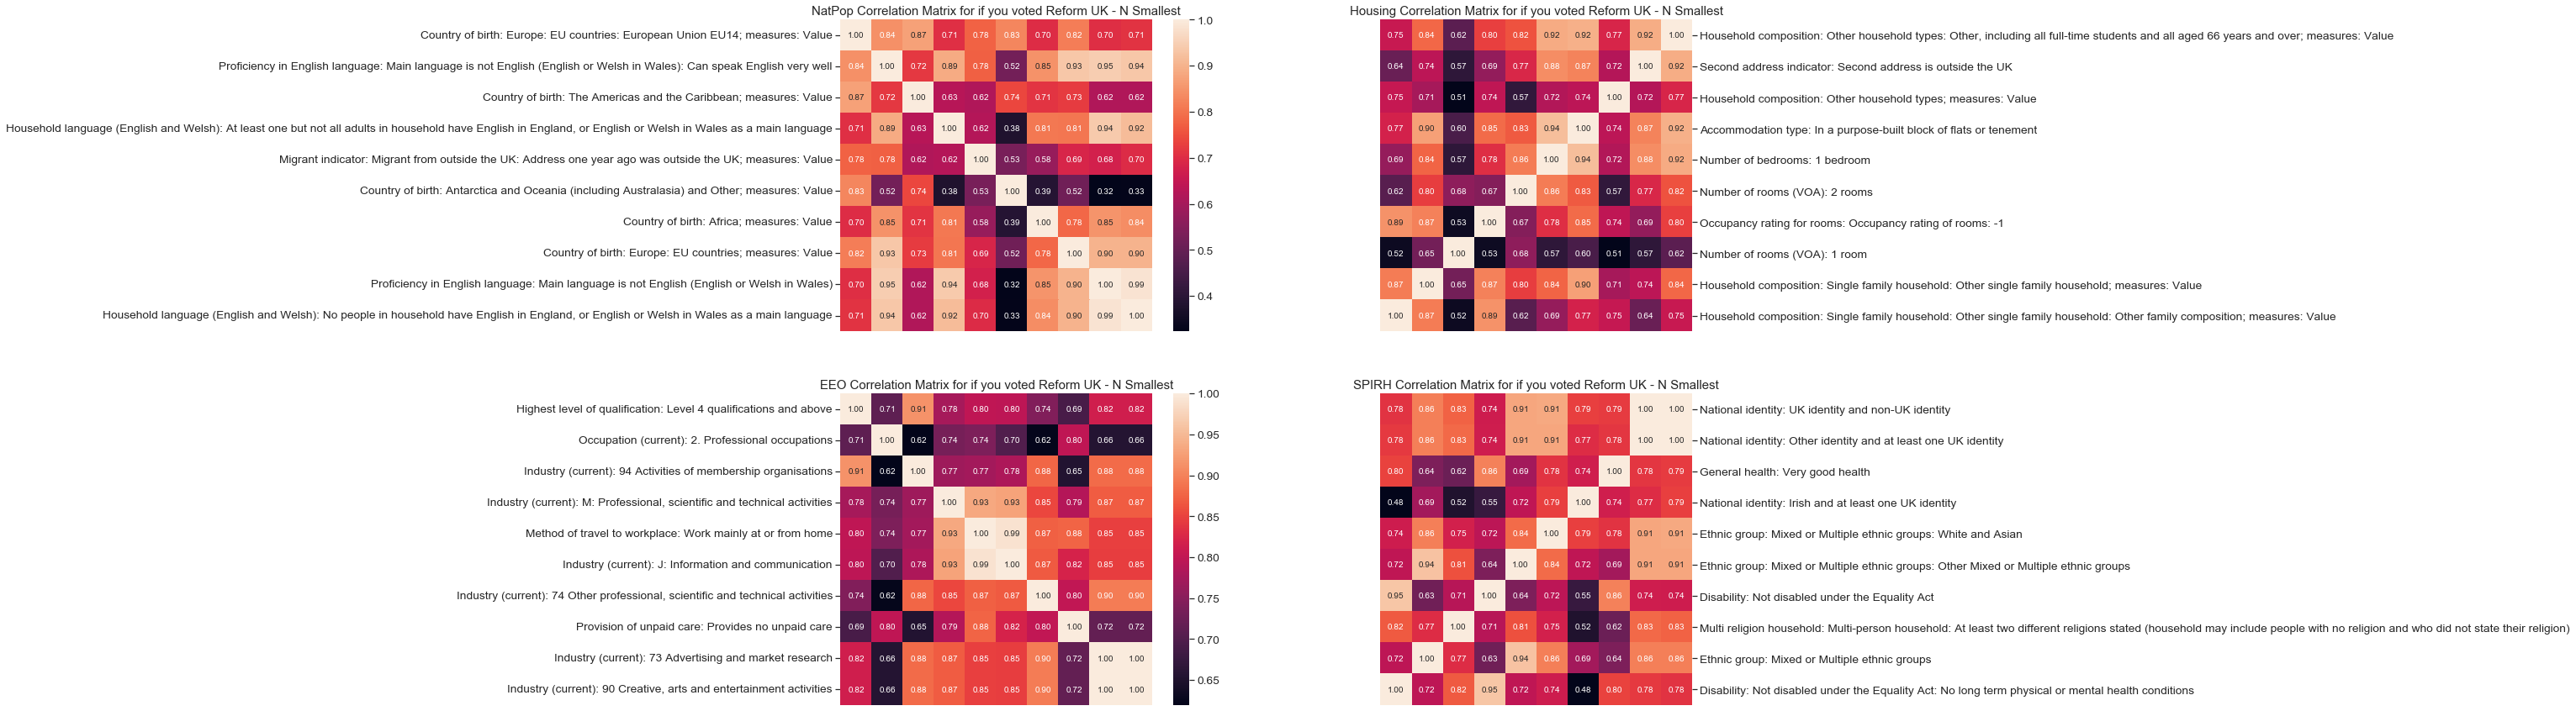

In [29]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'RUK')['RUK'].index
cols_eeo = corr_eeo.nsmallest(k, 'RUK')['RUK'].index
cols_housing = corr_housing.nsmallest(k, 'RUK')['RUK'].index
cols_spirh = corr_spirh.nsmallest(k, 'RUK')['RUK'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Reform UK - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Reform UK - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Reform UK - N Smallest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Reform UK - N Smallest')

plt.tight_layout
plt.show()

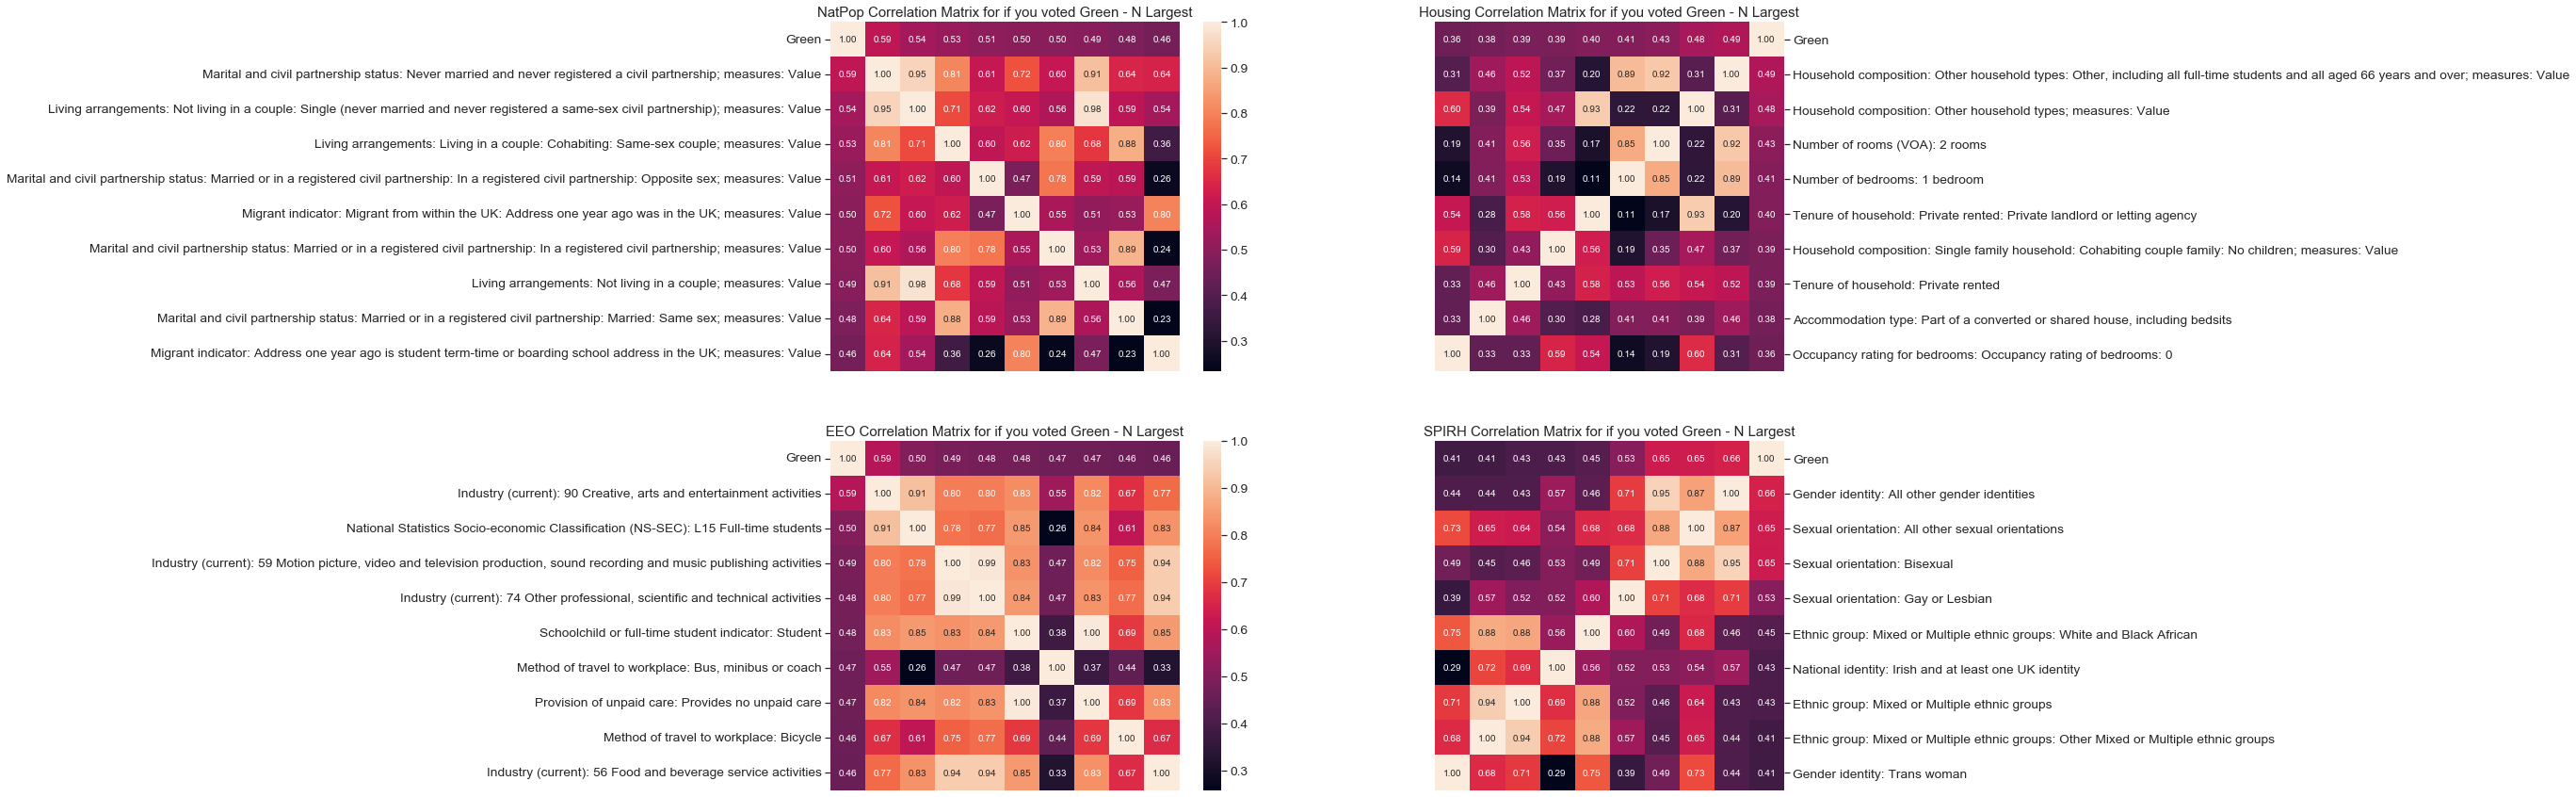

In [30]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'Green')['Green'].index
cols_eeo = corr_eeo.nlargest(k, 'Green')['Green'].index
cols_housing = corr_housing.nlargest(k, 'Green')['Green'].index
cols_spirh = corr_spirh.nlargest(k, 'Green')['Green'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Green - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Green - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Green - N Largest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Green - N Largest')

plt.tight_layout
plt.show()

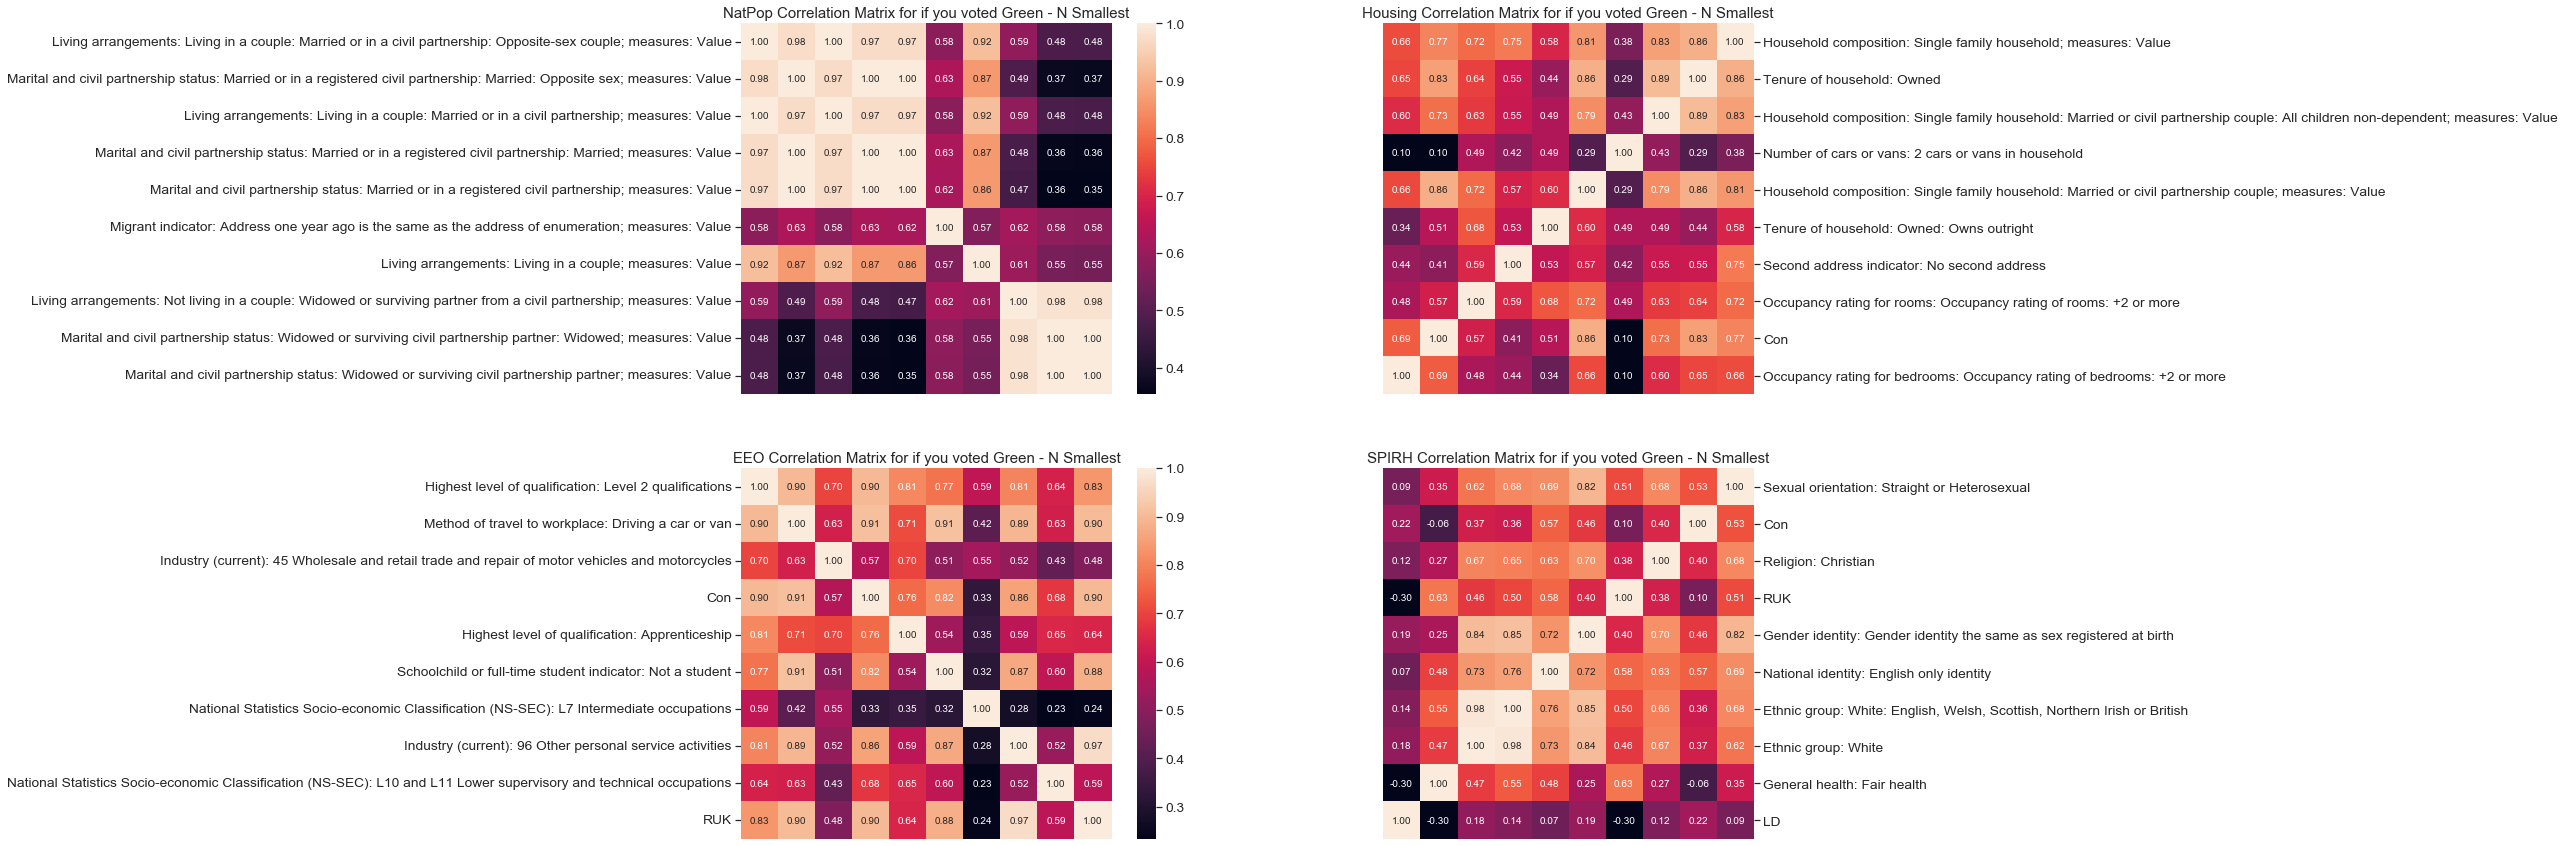

In [31]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'Green')['Green'].index
cols_eeo = corr_eeo.nsmallest(k, 'Green')['Green'].index
cols_housing = corr_housing.nsmallest(k, 'Green')['Green'].index
cols_spirh = corr_spirh.nsmallest(k, 'Green')['Green'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Green - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Green - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Green - N Smallest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Green - N Smallest')

plt.tight_layout
plt.show()

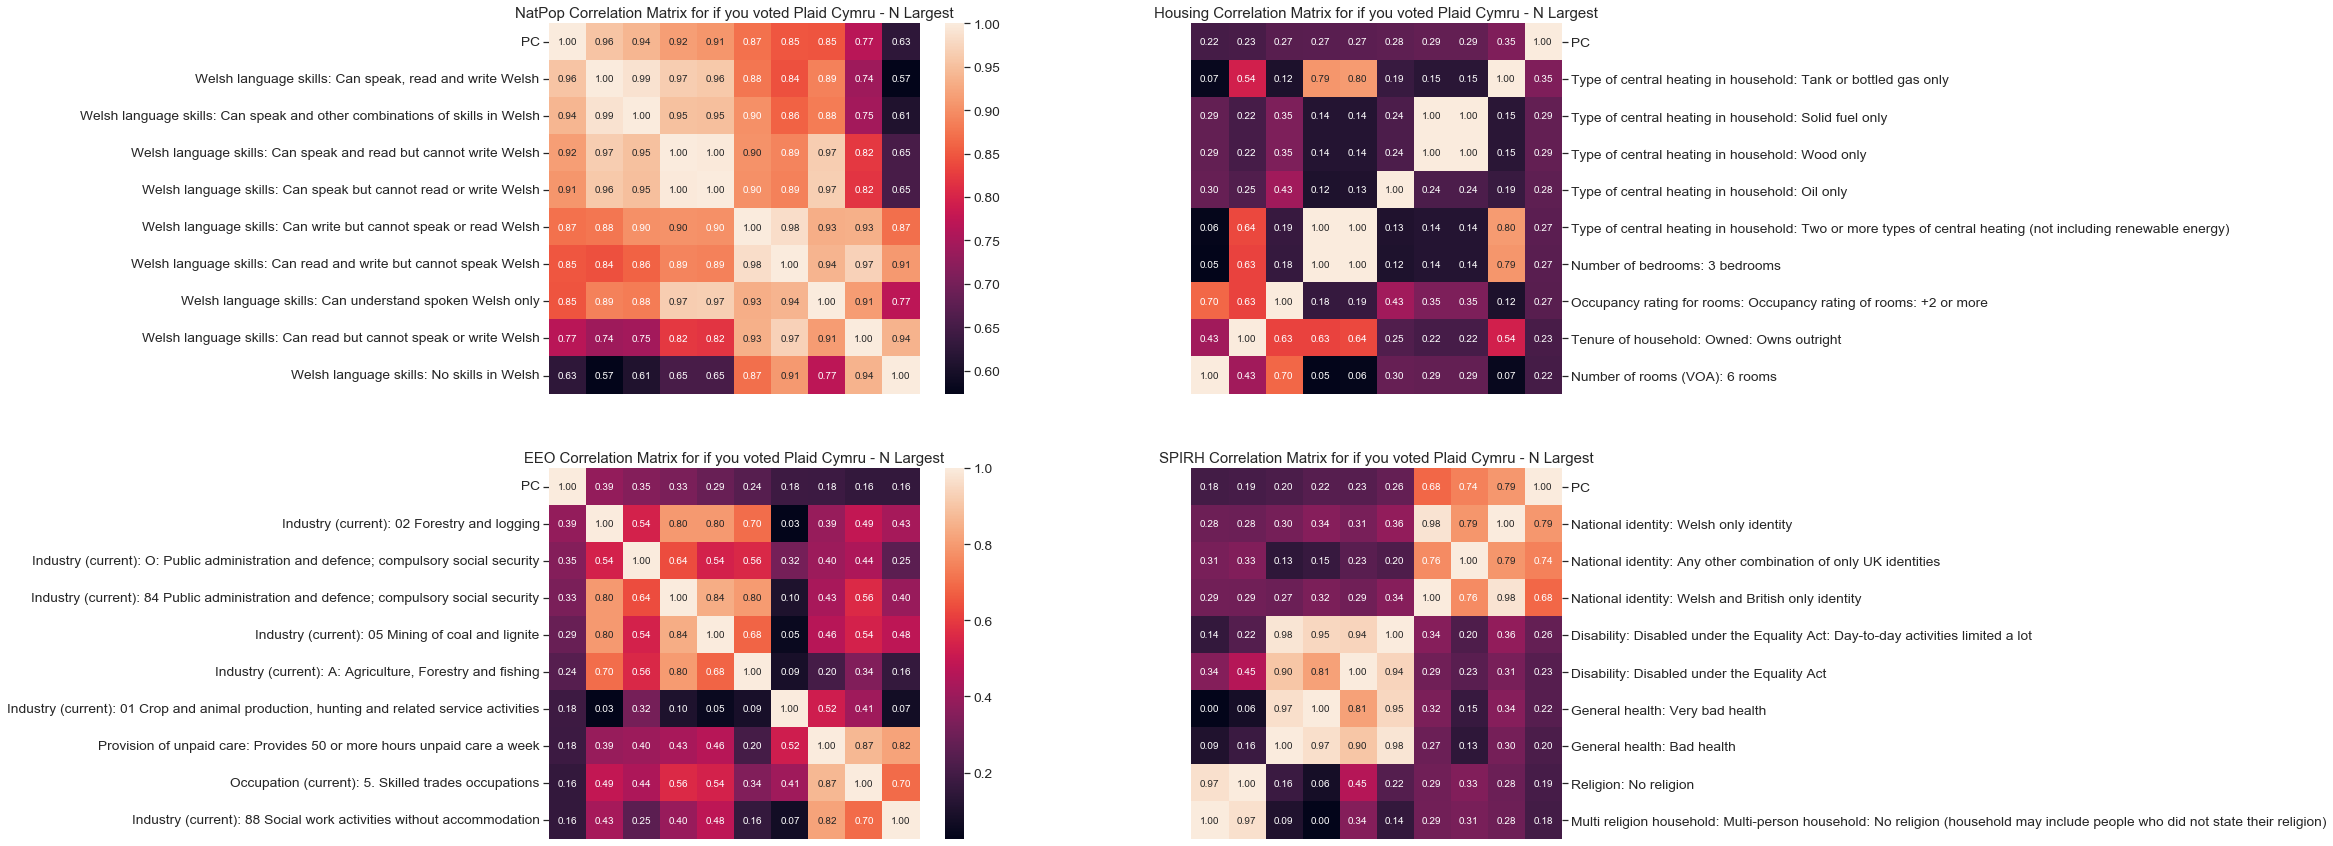

In [32]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'PC')['PC'].index
cols_eeo = corr_eeo.nlargest(k, 'PC')['PC'].index
cols_housing = corr_housing.nlargest(k, 'PC')['PC'].index
cols_spirh = corr_spirh.nlargest(k, 'PC')['PC'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Plaid Cymru - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Plaid Cymru - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Plaid Cymru - N Largest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Plaid Cymru - N Largest')

plt.tight_layout
plt.show()

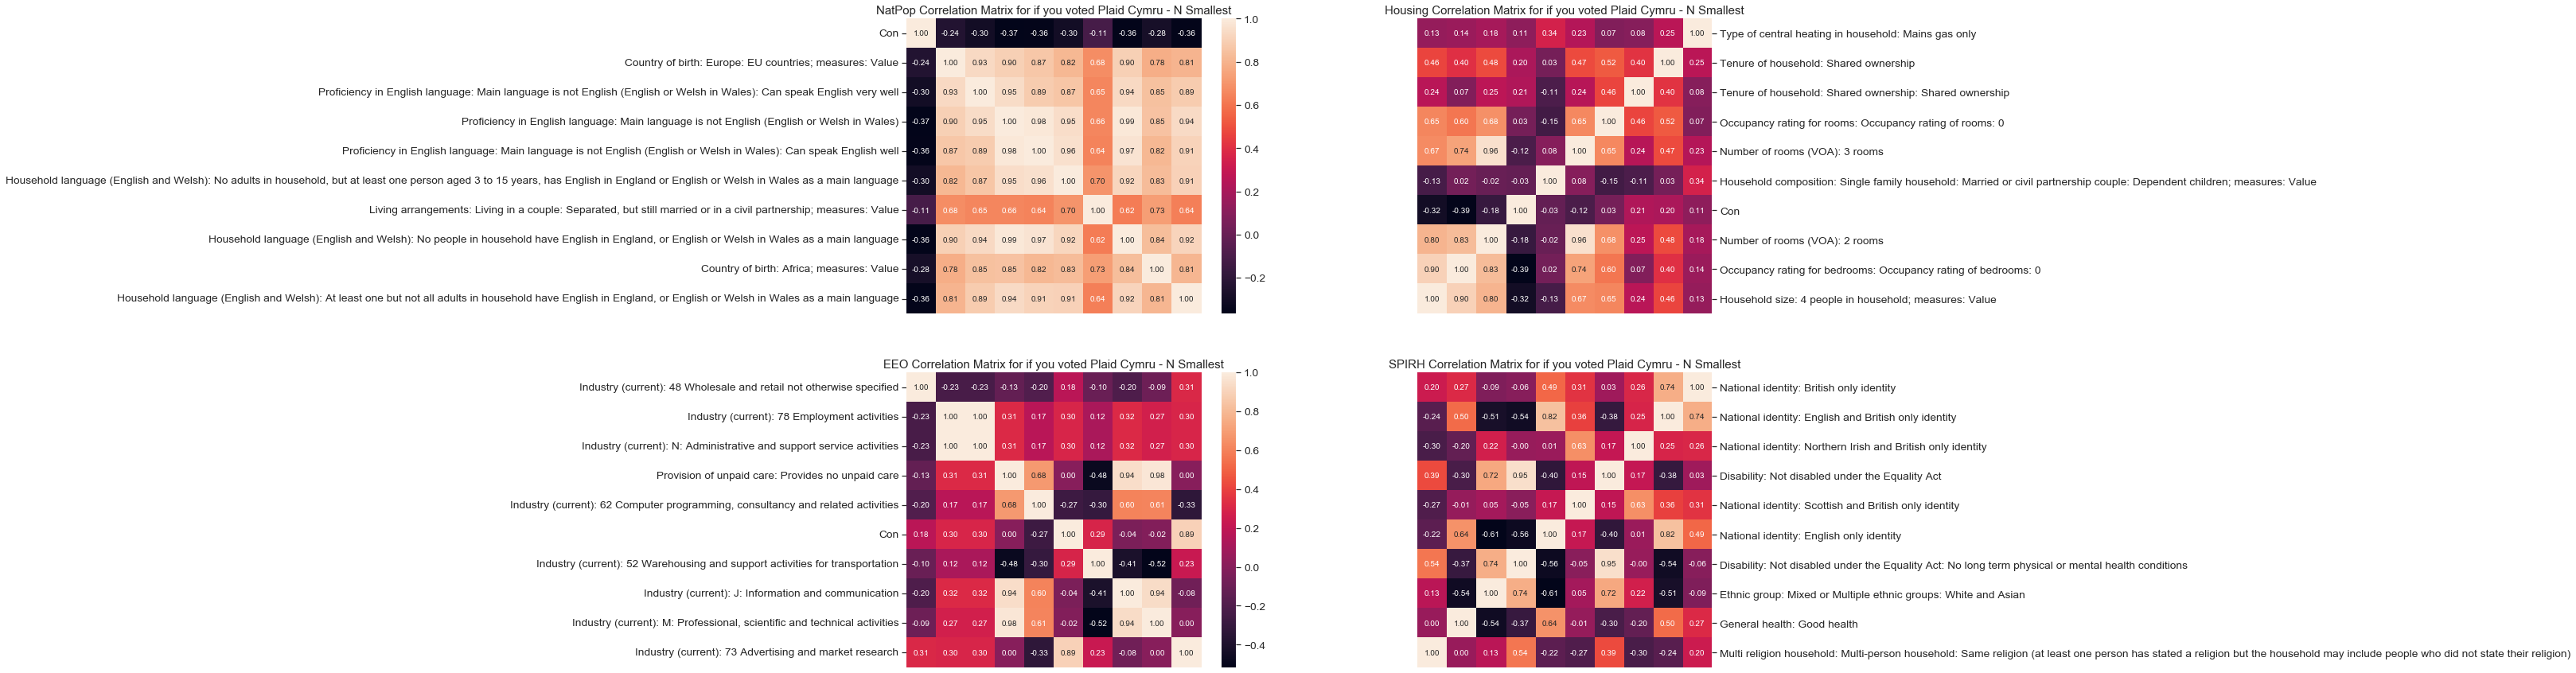

In [33]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'PC')['PC'].index
cols_eeo = corr_eeo.nsmallest(k, 'PC')['PC'].index
cols_housing = corr_housing.nsmallest(k, 'PC')['PC'].index
cols_spirh = corr_spirh.nsmallest(k, 'PC')['PC'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Plaid Cymru - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Plaid Cymru - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Plaid Cymru - N Smallest')
axes[1, 1].set_title('SPIRH Correlation Matrix for if you voted Plaid Cymru - N Smallest')

plt.tight_layout
plt.show()

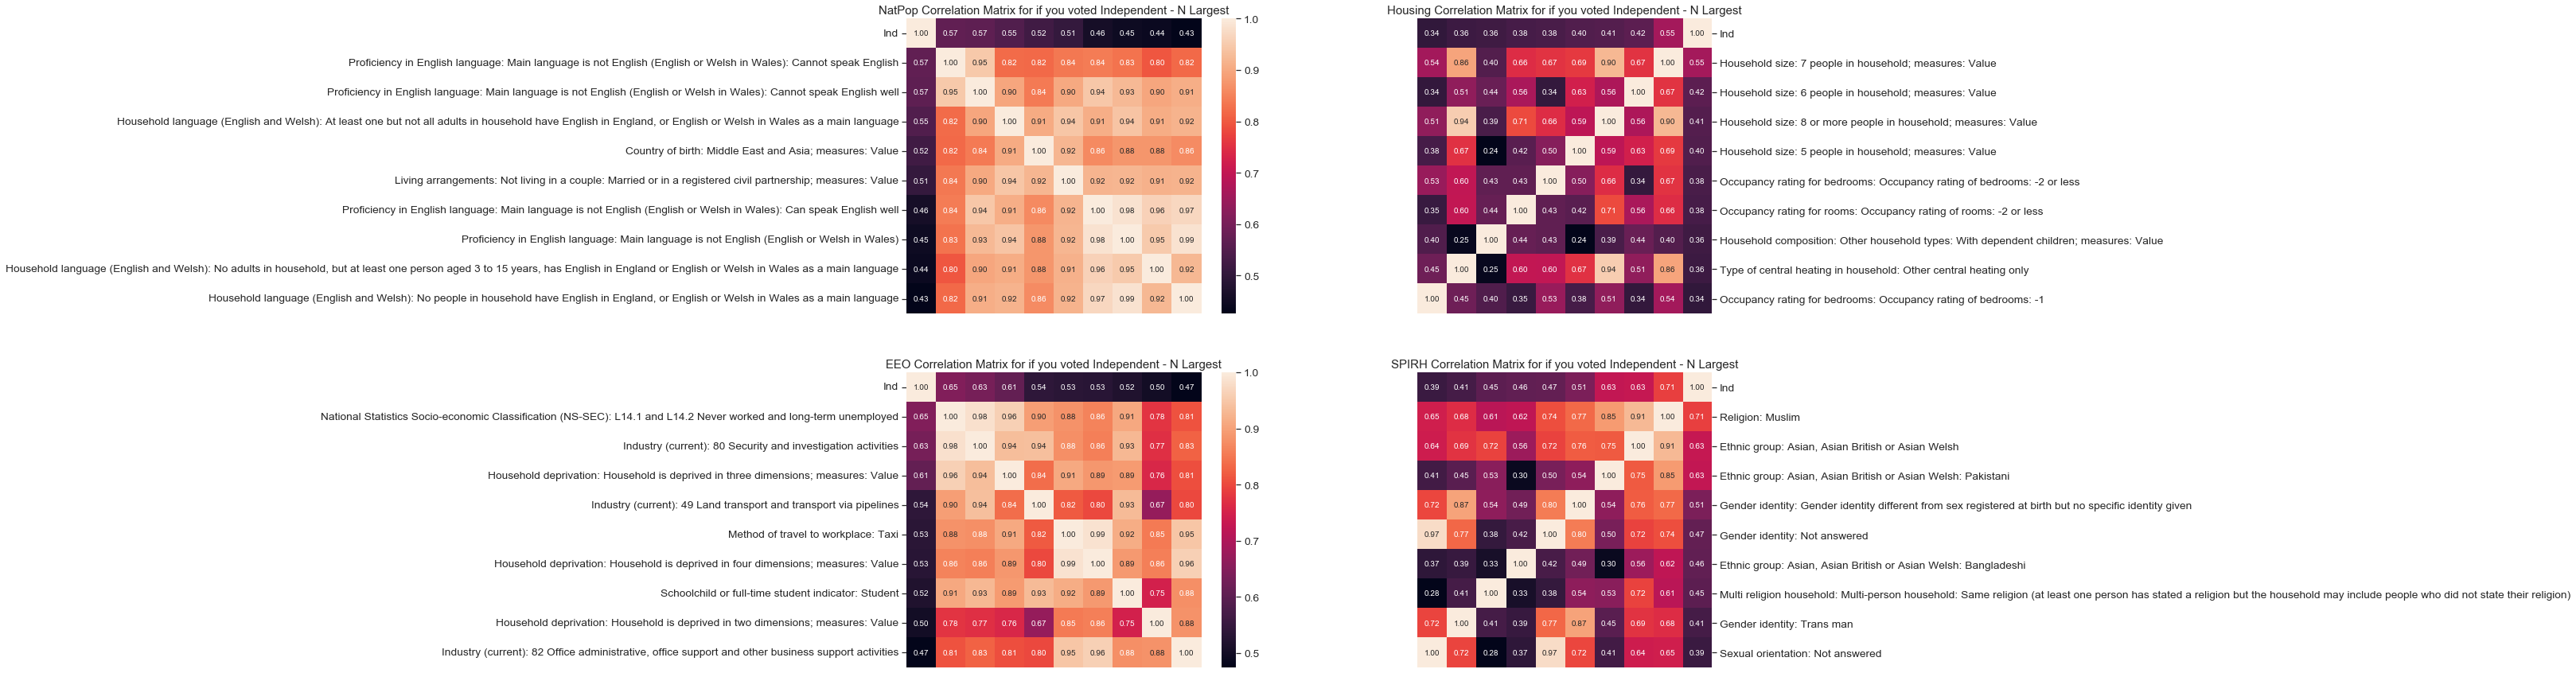

In [34]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nlargest(k, 'Ind')['Ind'].index
cols_eeo = corr_eeo.nlargest(k, 'Ind')['Ind'].index
cols_housing = corr_housing.nlargest(k, 'Ind')['Ind'].index
cols_spirh = corr_spirh.nlargest(k, 'Ind')['Ind'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Independent - N Largest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Independent - N Largest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Independent - N Largest')
axes[1,1].set_title('SPIRH Correlation Matrix for if you voted Independent - N Largest')

plt.tight_layout
plt.show()

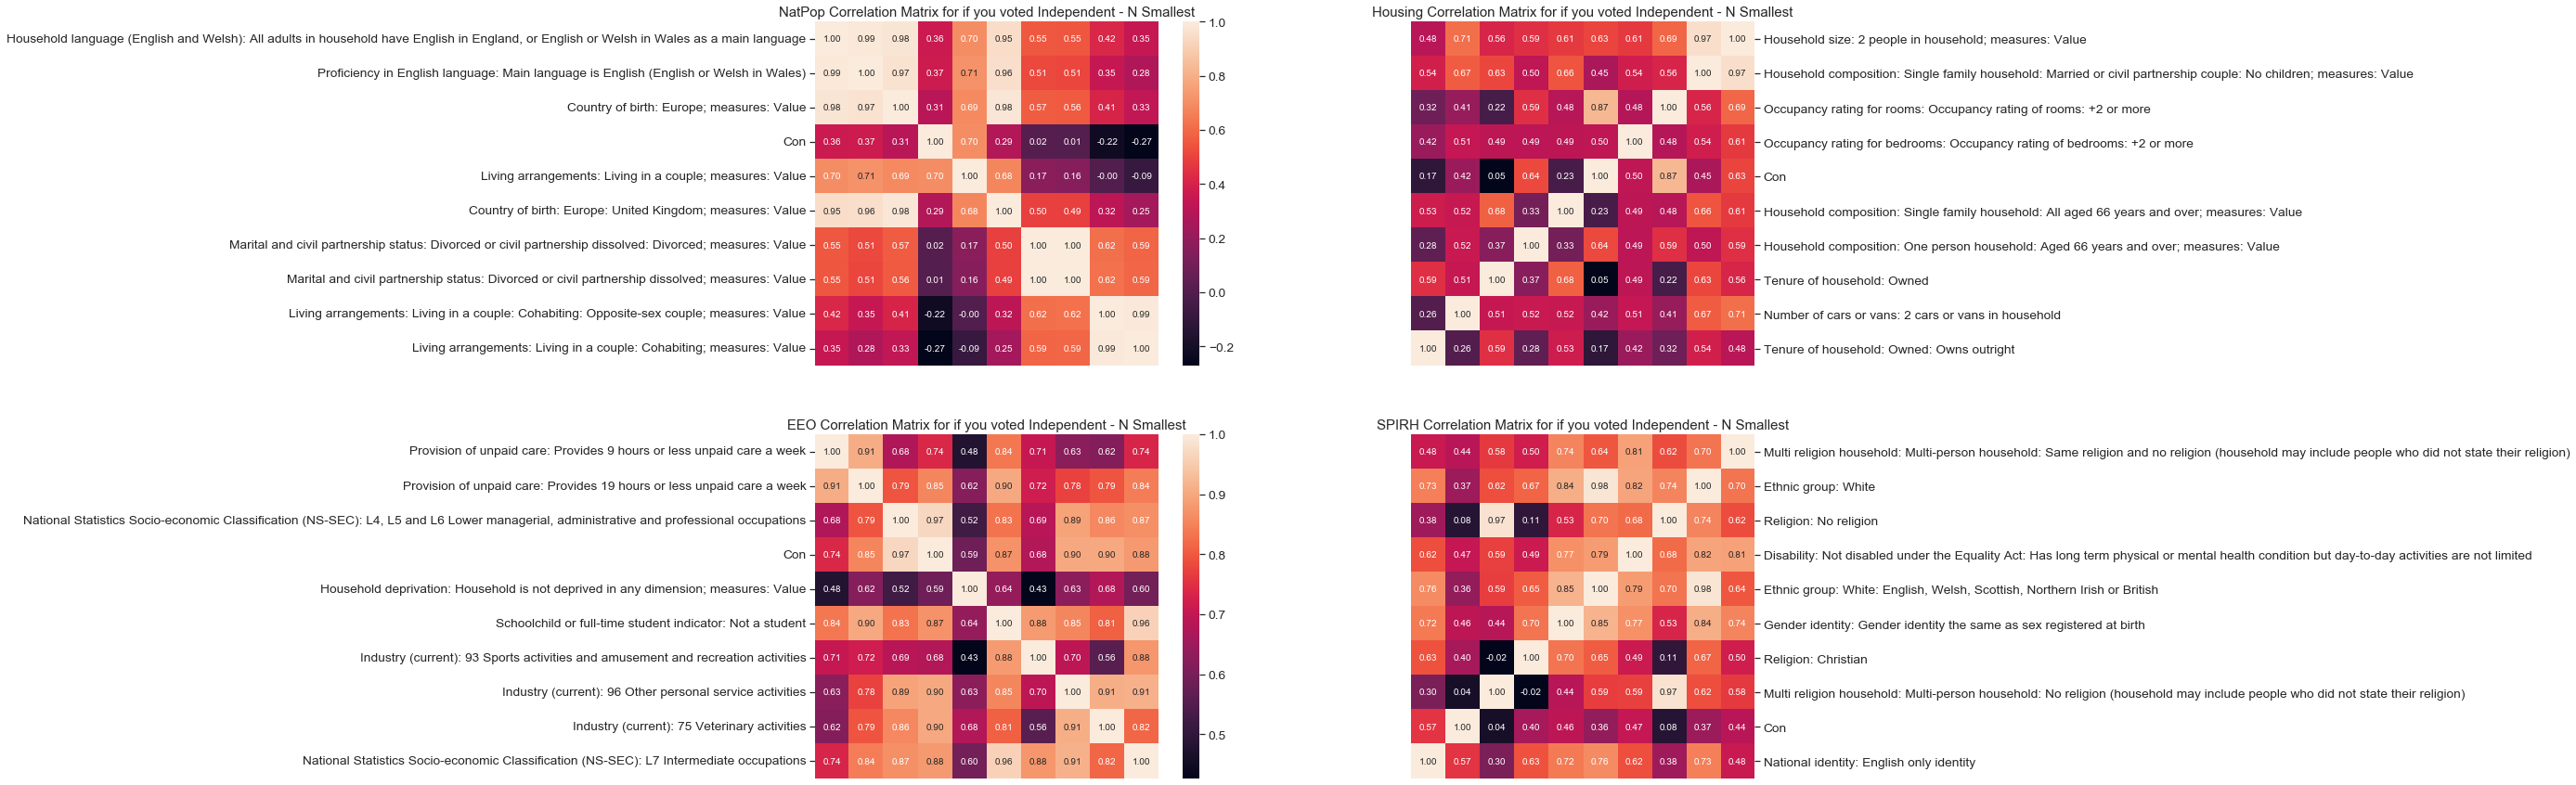

In [35]:
k = 10 #number of variables for heatmap
cols_natpop = corr_natpop.nsmallest(k, 'Ind')['Ind'].index
cols_eeo = corr_eeo.nsmallest(k, 'Ind')['Ind'].index
cols_housing = corr_housing.nsmallest(k, 'Ind')['Ind'].index
cols_spirh = corr_spirh.nsmallest(k, 'Ind')['Ind'].index

cm_n = np.corrcoef(census_natpop_GE2024_df_numeric[cols_natpop].values.T)
cm_e = np.corrcoef(census_eeo_GE2024_df_numeric[cols_eeo].values.T)
cm_h = np.corrcoef(census_housing_GE2024_df_numeric[cols_housing].values.T)
cm_s = np.corrcoef(census_spirh_GE2024_df_numeric[cols_spirh].values.T)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

sns.set(font_scale=1.25)
hm_n = sns.heatmap(cm_n, ax=axes[0, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_natpop.values, xticklabels=cols_natpop.values)
hm_n.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_h = sns.heatmap(cm_e, ax=axes[0, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_housing.values, xticklabels=cols_housing.values)
hm_h.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_h.invert_xaxis()
hm_e = sns.heatmap(cm_h, ax=axes[1, 0], cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_eeo.values, xticklabels=cols_eeo.values)
hm_e.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
hm_s = sns.heatmap(cm_s, ax=axes[1, 1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols_spirh.values, xticklabels=cols_spirh.values)
hm_s.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False, right=True, top=False, labelright=True, labeltop=False, labelrotation=0)
hm_s.invert_xaxis()

axes[0, 0].set_title('NatPop Correlation Matrix for if you voted Independent - N Smallest')
axes[0, 1].set_title('Housing Correlation Matrix for if you voted Independent - N Smallest')
axes[1, 0].set_title('EEO Correlation Matrix for if you voted Independent - N Smallest')
axes[1,1].set_title('SPIRH Correlation Matrix for if you voted Independent - N Smallest')

plt.tight_layout
plt.show()

## 2.2 Some other plots

Let's do some more plots to gleam some more info.

A pairplot could be handy to see how much how much voters bleed into each other. How convict in their votes are labour voters compared to plaid voters.
*The way I interpret these is that 'X axis' is our 'likelihood' to vote for that party and the 'y axis' is our 'shared probability' of voting for another party'*
- All of these should have a negative correlation; obviously, your're less likely to vote for one party the more likely you are to vote for another, but the intercept is interesting.
- Looking at Plaid, most cluster around 0 but that's because most people don't vote Plaid. But at the 'non-zero' values, we can that they tend to vote for Labour than Conservative (except at the extreme ends)
- This is mostly an exercise in me seeing what cool stuff I can gleam from this.

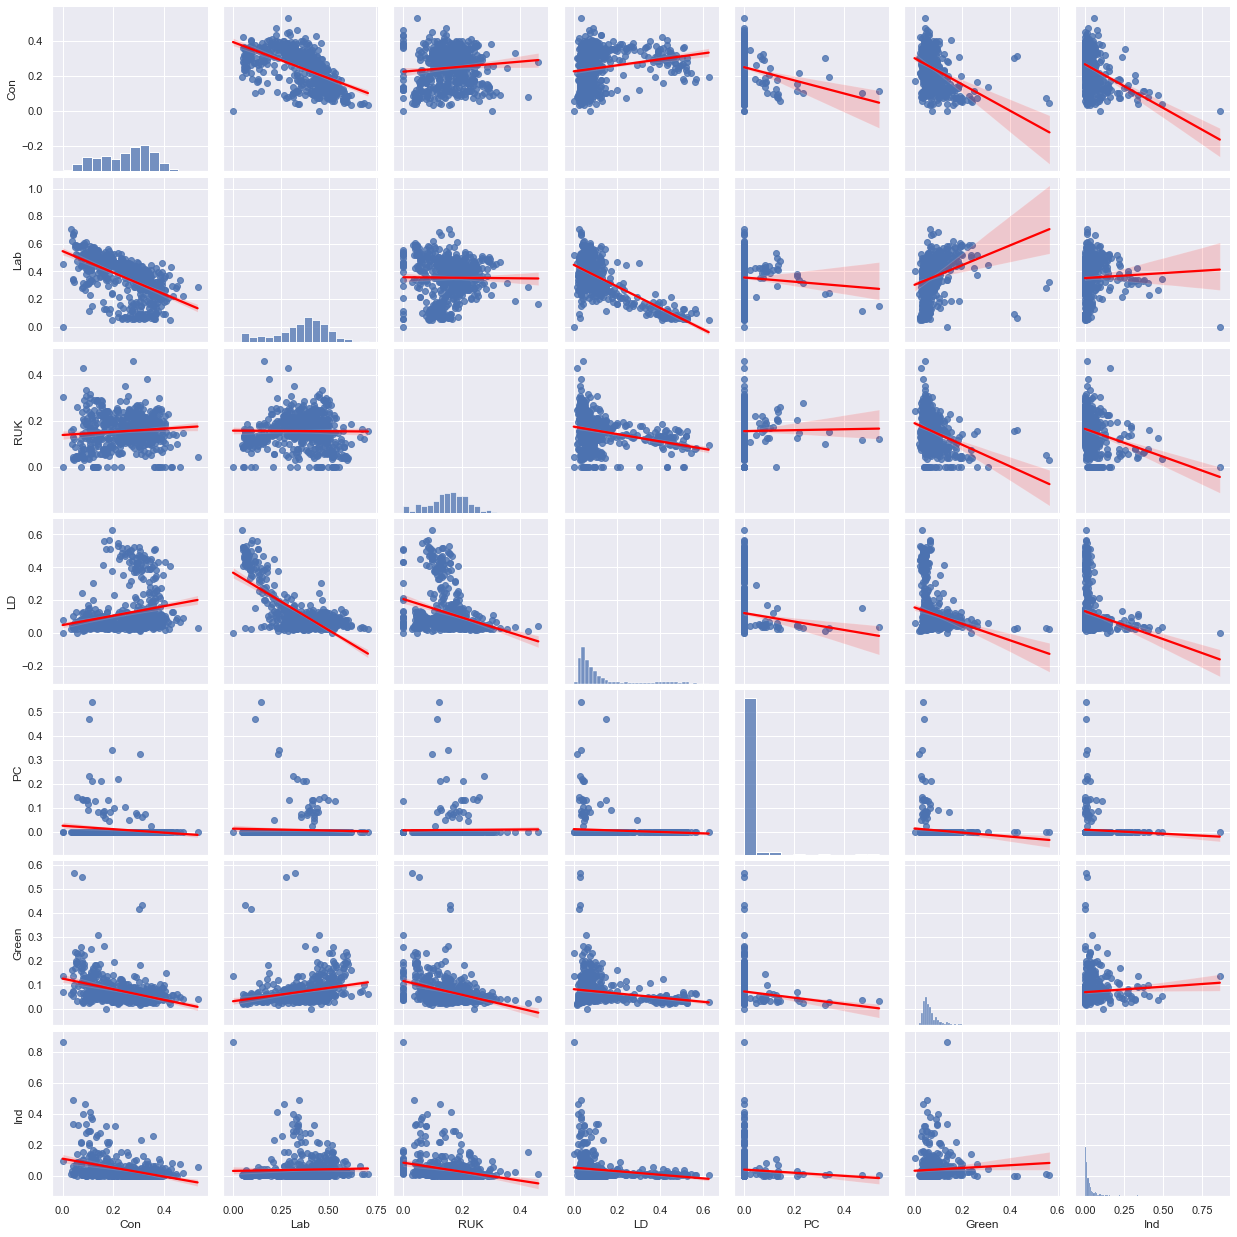

In [36]:
sns.set()
cols = ['Con', 'Lab', 'RUK', 'LD', 'PC', 'Green', 'Ind']
pp=sns.pairplot(census_natpop_GE2024_df[cols],kind='reg',plot_kws={'line_kws':{'color':'red'}})
plt.show()

I don't think this plot is very useful, but it's cool to look at.
I don't think this next plot is very useful either but I think it is very interesting. Basically, what did the share of the vote did a party win a constituency with. Basically tells us how popular the party was, the higher the mean, the more liked they were in the constituency.

In [37]:
lab = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'Lab']
con = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'Con']
ld = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'LD']
ruk = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'RUK']
green = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'Green']
pc = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'PC']
ind = census_natpop_GE2024_df[census_natpop_GE2024_df['Elected'] == 'Ind']

Text(0.5, 1.0, 'Vote share for (all) winning party of a Consituency')

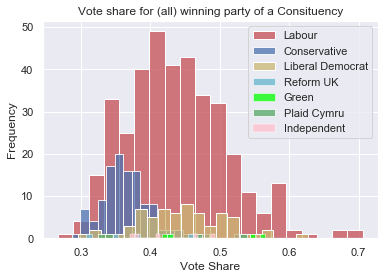

In [38]:
n_bins = 20
ax = sns.histplot(lab["Lab"], bins=n_bins, label = "Labour", color='r')
ax = sns.histplot(con["Con"], bins=n_bins, label = "Conservative", color='b')
ax = sns.histplot(ld["LD"], bins=n_bins, label = "Liberal Democrat", color='y')
ax = sns.histplot(ruk["RUK"], bins=n_bins, label = "Reform UK", color='c')
ax = sns.histplot(green["Green"], bins=n_bins, label = "Green", color='lime')
ax = sns.histplot(pc["PC"], bins=n_bins, label = "Plaid Cymru", color='g')
ax = sns.histplot(ind["Ind"], bins=n_bins, label = "Independent", color='pink')
ax.legend()
ax.set(xlabel='Vote Share', ylabel='Frequency')
ax.set_title('Vote share for (all) winning party of a Consituency')

Text(0.5, 1.0, 'Vote share for (smaller) winning party of a Consituency')

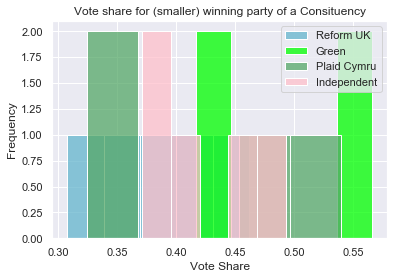

In [39]:
n_bins = 5
ax = sns.histplot(ruk["RUK"], bins=n_bins, label = "Reform UK", color='c')
ax = sns.histplot(green["Green"], bins=n_bins, label = "Green", color='lime')
ax = sns.histplot(pc["PC"], bins=n_bins, label = "Plaid Cymru", color='g')
ax = sns.histplot(ind["Ind"], bins=n_bins, label = "Independent", color='pink')
ax.legend()
ax.set(xlabel='Vote Share', ylabel='Frequency')
ax.set_title('Vote share for (smaller) winning party of a Consituency')

In [40]:
print("Labour - Description")
lab['Lab'].describe()

Labour - Description


count    374.000000
mean       0.437075
std        0.073527
min        0.267216
25%        0.385481
50%        0.432878
75%        0.482188
max        0.705742
Name: Lab, dtype: float64

In [41]:
print("Conservative - Description")
con['Con'].describe()

Conservative - Description


count    116.000000
mean       0.365237
std        0.038101
min        0.287006
25%        0.341226
50%        0.359545
75%        0.382944
max        0.533018
Name: Con, dtype: float64

In [42]:
print("Liberal Democrat - Description")
ld['LD'].describe()

Liberal Democrat - Description


count    66.000000
mean      0.445419
std       0.064063
min       0.295093
25%       0.398270
50%       0.445167
75%       0.490110
max       0.627077
Name: LD, dtype: float64

In [43]:
print("Reform UK - Description")
ruk['RUK'].describe()

Reform UK - Description


count    5.000000
mean     0.386846
std      0.060590
min      0.307922
25%      0.353023
50%      0.383636
75%      0.427812
max      0.461835
Name: RUK, dtype: float64

In [44]:
print("Green - Description")
green['Green'].describe()

Green - Description


count    4.000000
mean     0.491181
std      0.077676
min      0.417081
25%      0.427967
50%      0.490887
75%      0.554102
max      0.565871
Name: Green, dtype: float64

In [45]:
print("Plaid Cymru - Description")
pc['PC'].describe()

Plaid Cymru - Description


count    4.000000
mean     0.418436
std      0.103513
min      0.324568
25%      0.336383
50%      0.404902
75%      0.486956
max      0.539374
Name: PC, dtype: float64

In [46]:
print("Independent - Description")
ind['Ind'].describe()

Independent - Description


count    5.000000
mean     0.424112
std      0.052998
min      0.371346
25%      0.380644
50%      0.410848
75%      0.464885
max      0.492838
Name: Ind, dtype: float64

Frankly, it's clear that the Conservatives, Independent and Reform UK were unpopular and won by a very small margin quite often. Compared to Liberal Democrats, Green, Plaid Cymru and Labour who hover just about the 50% mark, so not quite the "clear majority" but more support than the cons.
However, it is quite clear that Independent, Plaid, Green and Reform comprise a small portion of the actual data set so it's likely that these will have very poor fits.

# 3. Individual Models
So let's build our ML model then.

Just thinking actually, I said there are 575 constituencies. 32 in Wales and 543 in England. If we do a 60-20-20 split, that would mean that Wales (in an ideal random split) would have constituency make-up like 20-6-6, or 19-7-6, or some other similar permutation.
This does mean all of the PC votes (a total of 4), could end up in one split. Which would be bad for the other two splits. This also follows with Green and Reform, as these also have a small pool of data to pull from. 
It may be wise to group these smaller parties into an 'other' category.

Despite my joined Census-Election dataframe, I'm going to go back to my separated table as that's basically my X and Y there.

In [47]:
X1 = census_housing_pcon_df.copy()
X2 = census_eeo_pcon_df.copy()
X3 = census_spirh_pcon_df.copy()
X4 = census_natpop_pcon_df.copy()
# Merge them together
X = X1.merge(X2, on='PCON25CD', how='inner', copy=False)
X = X.merge(X3, on='PCON25CD', how='inner', copy=False)
X = X.merge(X4, on='PCON25CD', how='inner', copy=False)

X_index = X["PCON25CD"] # Index list (just in case)
X.drop(columns=['PCON25CD'], inplace=True, axis=1)  # drop useless cols
X.head()


Household composition: One person household; measures: Value  \
0                                           0.101724              
1                                           0.110413              
2                                           0.107241              
3                                           0.120456              
4                                           0.113074              

   Household composition: One person household: Aged 66 years and over; measures: Value  \
0                                           0.041287                                      
1                                           0.061412                                      
2                                           0.053361                                      
3                                           0.054911                                      
4                                           0.067652                                      

   Household composition: One person household: Other; measures: Value  \
0                                           0.060437                     
1                                           0.049002                     
2                                           0.053880                     
3                                           0.065546                     
4                                           0.045423                     

   Household composition: Single family household; measures: Value  \
0                                           0.255442                 
1                                           0.262932                 
2                                           0.264396                 
3                                           0.258307                 
4                                           0.267790                 

   Household composition: Single family household: All aged 66 years and over; measures: Value  \
0                                           0.031313                                             
1                                           0.047432                                             
2                                           0.039670                                             
3                                           0.043330                                             
4                                           0.063775                                             

   Household composition: Single family household: Married or civil partnership couple; measures: Value  \
0                                           0.135045                                                      
1                                           0.127846                                                      
2                                           0.149831                                                      
3                                           0.118261                                                      
4                                           0.136403                                                      

   Household composition: Single family household: Married or civil partnership couple: No children; measures: Value  \
0                                           0.041287                                                                   
1                                           0.041350                                                                   
2                                           0.037687                                                                   
3                                           0.049547                                                                   
4                                           0.054970                                                                   

   Household composition: Single family household: Married or civil partnership couple: Dependent children; measures: Value  \
0                                           0.066815                                                       

In [48]:
Y = GE2024_frac_df.copy()
#other_cols = ['PC', 'RUK', 'Green','Ind','LD']
#Y['Other'] = Y[other_cols].sum(axis=1)
#Y.drop(columns=other_cols, inplace=True)
Y.drop(columns=["PCON25NM"], inplace=True)
#Y['Elected'].replace({'LD':'Other','PC':'Other','RUK':'Other','Green':'Other','Ind':'Other'}, inplace=True)
Y.head()

PCON25CD Elected       Con       Lab        LD       RUK     Green  \
0  W07000081     Lab  0.081191  0.498895  0.025619  0.209313  0.030597   
1  S14000060     SNP  0.213373  0.463428  0.093716  0.137182  0.046259   
2  S14000061     SNP  0.362971  0.367949  0.093826  0.102756  0.051683   
3  S14000062     SNP  0.505923  0.156714  0.112481  0.224882  0.000000   
4  S14000063     Lab  0.066924  0.744653  0.028609  0.117236  0.000000   

         PC       Ind  
0  0.131982  0.022402  
1  0.000000  0.046042  
2  0.000000  0.020815  
3  0.000000  0.000000  
4  0.000000  0.042578

This caused more annoyance than it should but I couldn't work out what party "Spk" was then I realised it was the Speaker.
So drop row 137 to bin him off

In [49]:
# Get rid of the speaker
X = X.drop(137)
Y = Y.drop(137)

# Calculate the proportion of votes that labour got
lab_count = Y['Elected'].value_counts().get('Lab', 0)
total_count = Y['Elected'].count()
lab_percentage = (lab_count  / total_count) * 100
print("Labour obtained: %.2f%% of the constituencies" % lab_percentage)

Labour obtained: 63.33% of the constituencies


As we can see Labour have a lot more than 25% of the seats, so we can assume that actually our null hypothesis would be that "Our model is no better than just guessing labour" which should have an accuracy of approximately 65%.

We need to ensure our model is accurate more than 65% for us to be able to say that it's actually doing anything.

I did initially separate these into 'other' but we can't do this for regressors

Now I can't decided if the 'Elected' Tab or the Percent Tabs are better so I'll just separate these into two different ones.

Also let's delete the Scottish and Irish data.

In [50]:
Y = Y[Y["PCON25CD"].str.contains("S") == False]
Y = Y[Y["PCON25CD"].str.contains("N") == False]
Y_index = Y["PCON25CD"]
Y1 = Y.copy().drop(columns=['Elected','PCON25CD'])
Y2 = Y.copy().loc[:, 'Elected']
Y1.head()

Con       Lab        LD       RUK     Green        PC       Ind
0  0.081191  0.498895  0.025619  0.209313  0.030597  0.131982  0.022402
5  0.290067  0.407136  0.083471  0.169125  0.044393  0.000000  0.005809
6  0.388663  0.283706  0.042897  0.242056  0.042677  0.000000  0.000000
8  0.323097  0.404221  0.091872  0.096420  0.071892  0.000000  0.012497
9  0.181877  0.423926  0.047589  0.221262  0.044386  0.044663  0.036297

In [51]:
Y2.head()

0    Lab
5    Lab
6    Con
8    Lab
9    Lab
Name: Elected, dtype: object

We need to get "SMOTE" in here as the size of any other party (and Independent) compared to Labour is tiny. So we'll oversample to get some more data!

In [52]:
party_to_num_map = {'Lab': 0, 'Con': 1, 'LD': 2, 'Green': 3, 'RUK': 4, 'PC': 5, 'Ind': 6}
num_to_party_map = {v: k for k, v in party_to_num_map.items()}
Y2.replace(party_to_num_map,inplace=True)
#Y2 = pd.to_numeric(Y2, errors='coerce')

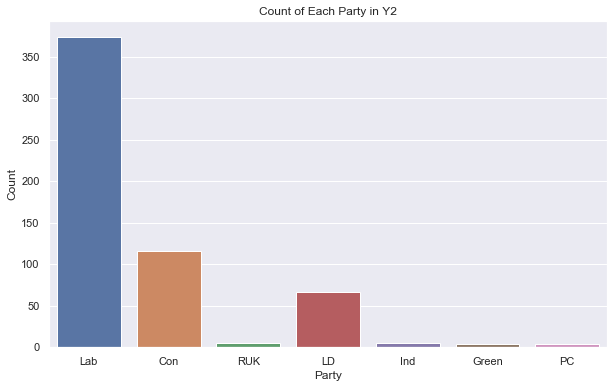

In [53]:
# Plot a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=Y2.replace(num_to_party_map))
plt.title('Count of Each Party in Y2')
plt.xlabel('Party')
plt.ylabel('Count')
plt.show()

In [54]:
sm = SMOTE(random_state=42, k_neighbors=3)
X_res, Y2_res = sm.fit_resample(X, Y2)

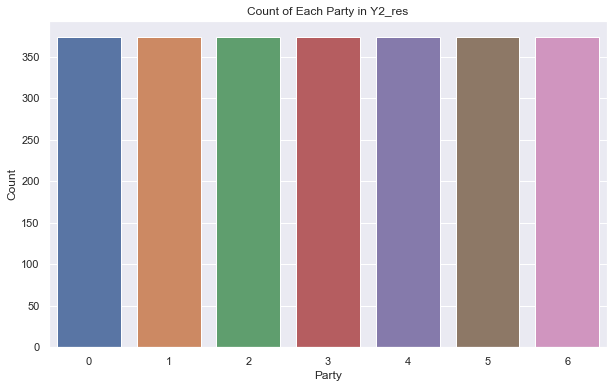

In [55]:
# Plot a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x=Y2_res)
plt.title('Count of Each Party in Y2_res')
plt.xlabel('Party')
plt.ylabel('Count')
plt.show()

In [56]:
"""kbins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
Y1_binned = kbins.fit_transform(Y1.to_numpy().reshape(-1, 1)).ravel()
print(Y1_binned)"""
"""smote = SMOTE(random_state=42)
X_res, Y1_res = smote.fit_resample(X, Y1)
print(Y1)"""

'smote = SMOTE(random_state=42)\nX_res, Y1_res = smote.fit_resample(X, Y1)\nprint(Y1)'

In [57]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X, Y1, test_size=0.2, random_state=random_code)
x2_train, x2_test, y2_train, y2_test = train_test_split(X_res, Y2_res, test_size=0.2, random_state=random_code)

Okay so this is our final total in the test data, we have to get a 62% or better technically. But, should aim for 65%.
*We can go into significance later. Let's just aim for better than 65% for now.*

## 3.1 Decision Tree Classifier

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2113 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 2558 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 3960 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 5040 out of 5040 | elapsed:  1.6min finished


Best parameters found:  {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}


c:\Users\roryj\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


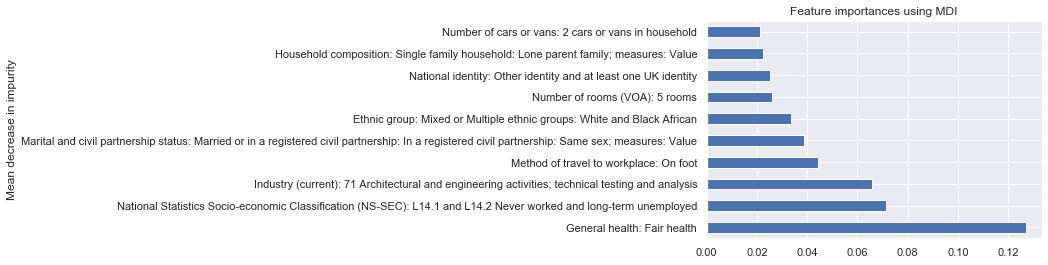

Accuracy: 0.76


"plt.figure(figsize = [60.0, 20.0])\n\nclass_names = [str(cls) for cls in tree.classes_]\n\n_ = plot_tree(tree, \n              feature_names = x2_test.columns, \n              class_names = class_names,\n              filled = True, \n              rounded = False, \n              proportion = True, \n              fontsize = 11) \nfor o in _:\n    arrow = o.arrow_patch\n    if arrow is not None:\n        arrow.set_edgecolor('red')\n        arrow.set_linewidth(3)"

In [58]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None,5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Define an initial tree
tree = DecisionTreeClassifier(random_state = random_code)

# Perform Grid Search
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x2_train, y2_train)
best_params = grid_search.best_params_

print("Best parameters found: ", best_params)

# Build a new tree based on the best parameters
tree_best = DecisionTreeClassifier(**best_params, random_state=random_code)
tree_best.fit(x2_train, y2_train)
tree_best.score(x2_train,y2_train)

# Define the feature importances and sort them in descending order
importances = tree_best.feature_importances_
indices = np.argsort(importances)[::-1]

"""print("Feature ranking:")
for f in range(x2_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")"""
    
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Calculate the importances and standard deviations for the top features
plot_importances = tree_best.feature_importances_[top_features_indices]

# Create a Series for the top feature importances
tree_importances = pd.Series(plot_importances, index=top_features)

# Plot the importances with error bars
fig, ax = plt.subplots()
tree_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Select the top features from the DataFrame
x2_train_top = x2_train[top_features]
x2_test_top = x2_test[top_features]

# Train the model with top features
tree_top = DecisionTreeClassifier(**best_params, random_state=random_code)
tree = tree_top.fit(x2_train_top, y2_train)
tree_prediction = tree.predict(x2_test_top)

print("Accuracy:", round(accuracy_score(y2_test,tree_prediction), 3))

"""plt.figure(figsize = [60.0, 20.0])

class_names = [str(cls) for cls in tree.classes_]

_ = plot_tree(tree, 
              feature_names = x2_test.columns, 
              class_names = class_names,
              filled = True, 
              rounded = False, 
              proportion = True, 
              fontsize = 11) 
for o in _:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('red')
        arrow.set_linewidth(3)"""

## 3.2 Random Forest Classifier
Let's first try with a random forest. We'll start with some initial values and do our model optimisation later.

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  8.8min finished


Best parameters found:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


c:\Users\roryj\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


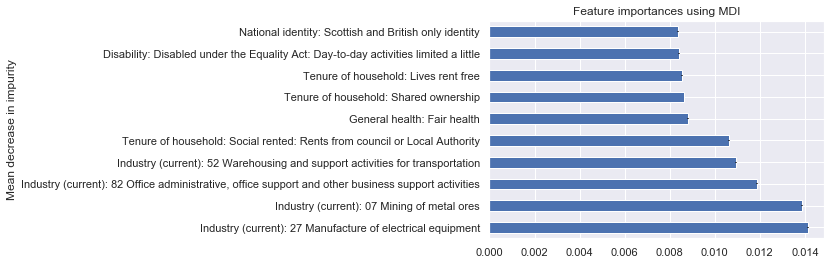

The CV Score for the training data is 0.905%, and for the test data it is 0.771%
Accuracy: 0.905


In [59]:
# Init the param grid and the model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rfc_ = RandomForestClassifier(random_state = random_code)

# Grid search to find the best parameters
grid_search = GridSearchCV(estimator=rfc_, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x2_train, y2_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Generate new model and predict based on the best parameters
rfc_best = RandomForestClassifier(**best_params, random_state=random_code)
rfc = rfc_best.fit(x2_train,y2_train)

# Get the feature importances and sort them in descending order
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

"""print("Feature ranking:")
for f in range(x2_train.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")"""
    
# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Calculate the importances and standard deviations for the top features
plot_importances = rfc.feature_importances_[top_features_indices]
std = np.std([tree.feature_importances_[top_features_indices] for tree in rfc.estimators_], axis=0)

# Create a Series for the top feature importances
forest_importances = pd.Series(plot_importances, index=top_features)

# Plot the importances with error bars
fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Select the top features from the DataFrame
x2_train_top = x2_train[top_features]
x2_test_top = x2_test[top_features]

# Train the model with top features
rfc_top = RandomForestClassifier(**best_params, random_state=random_code)
rfc = rfc_top.fit(x2_train_top, y2_train)

# Cross validate the accuracy
accuracyRFC_train = cross_val_score(estimator=rfc, X = x2_train_top, y = y2_train, cv=5)
accuracyRFC_test = cross_val_score(estimator=rfc, X = x2_test_top, y = y2_test, cv=5)
print("The CV Score for the training data is %.3f%%, and for the test data it is %.3f%%" %(accuracyRFC_train.mean(), accuracyRFC_test.mean()))

# Calculate the predictive accuracy
rfc_predictions = rfc.predict(x2_test_top)
print("Accuracy:", round(accuracy_score(y2_test,rfc_predictions), 3))

## 3.3 Random Forest Regressor.
----- UN-USED -----

In [60]:
"""param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rfr_ = RandomForestRegressor(random_state = random_code)
grid_search = GridSearchCV(estimator=rfr_, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x1_train, y1_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
rfr_best_search = RandomForestRegressor(**best_params, random_state=random_code)
rfr_best_search.fit(x1_train, y1_train)
search_score = rfr_best_search.score(x1_train,y1_train)
print(search_score)
rfr_ = RandomForestRegressor(random_state = random_code)
grid_search = RandomizedSearchCV(estimator=rfr_, param_distributions=param_grid, cv=3, n_jobs=-1, n_iter=20)
grid_search.fit(x1_train, y1_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
rfr_best_random = RandomForestRegressor(**best_params, random_state=random_code)
rfr_best_random.fit(x1_train, y1_train)
random_score = rfr_best_random.score(x1_train,y1_train)
print(random_score)
if random_score > search_score:
    rfr_best = rfr_best_random
else:
    rfr_best = rfr_best_search
importances = rfr_best.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(min(10, x1_train.shape[1])):  # Ensure we do not exceed the number of features
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")
    
# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x1_train.columns[top_features_indices]

# Calculate the importances and standard deviations for the top features
plot_importances = rfr_best.feature_importances_[top_features_indices]
std = np.std([tree.feature_importances_[top_features_indices] for tree in rfr_best.estimators_], axis=0)

# Create a Series for the top feature importances
forest_importances = pd.Series(plot_importances, index=top_features)

# Plot the importances with error bars
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x1_train.columns[top_features_indices]

# Select the top features from the DataFrame
x1_train_top = x1_train[top_features]
x1_test_top = x1_test[top_features]

# Train the model with top features
rfr_top = RandomForestRegressor(**best_params, random_state=random_code)
rfr = rfr_top.fit(x1_train_top, y1_train)
print(rfr.score(x1_train_top, y1_train))
rfr_predictions = rfr.predict(x1_test_top)
rfr_predictions"""
"""columns = y1_test.columns
for idx, col in enumerate(columns):
    plt.plot(y1_test[col], rfr_predictions[:, columns.get_loc(col)], 'o', label=col)
    # Calculate regression metrics
    mse = mean_squared_error(y1_test[col], rfr_predictions[:,idx])
    mae = mean_absolute_error(y1_test[col], rfr_predictions[:,idx])
    r2 = r2_score(y1_test[col], rfr_predictions[:,idx])
    print(col,": Mean Squared Error (MSE):", round(mse, 2))
    print(col,": Mean Absolute Error (MAE):", round(mae, 2))
    print(col,": R² Score:", round(r2, 2))
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor Predictions')

plt.legend()"""
"""columns = y1_test.columns
colours = ['b','r','orange','cyan','olivedrab','springgreen','pink']
plt.figure(figsize=(20,14))
for idx, col in enumerate(columns):
    ax = sns.regplot(x=y1_test[col], y=rfr_predictions[:,idx], ci=100, line_kws={'color':'red'},label=col, color=colours[idx])
    mean_prediction = rfr_predictions[:, idx].mean()
    mean_test = y1_test[col].mean()
    ax.scatter(mean_test,mean_prediction, color='k',s=300, marker='o')
    ax.scatter(mean_test,mean_prediction, color=colours[idx],s=200, marker='o')
    # Calculate regression metrics
    mse = mean_squared_error(y1_test[col], rfr_predictions[:,idx])
    mae = mean_absolute_error(y1_test[col], rfr_predictions[:,idx])
    r2 = r2_score(y1_test[col], rfr_predictions[:,idx])
    print(col,": Mean Squared Error (MSE):", round(mse, 2))
    print(col,": Mean Absolute Error (MAE):", round(mae, 2))
    print(col,": R² Score:", round(r2, 2))
ax.legend()
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('Random Forest Regressor Predictions')
rfr_predictions_trans = []
for row in rfr_predictions:
    rfr_predictions_trans.append(columns[np.argmax(row)])
print(rfr_predictions_trans)
print("Accuracy:", round(accuracy_score(y2_test,rfr_predictions_trans), 3))"""

'columns = y1_test.columns\ncolours = [\'b\',\'r\',\'orange\',\'cyan\',\'olivedrab\',\'springgreen\',\'pink\']\nplt.figure(figsize=(20,14))\nfor idx, col in enumerate(columns):\n    ax = sns.regplot(x=y1_test[col], y=rfr_predictions[:,idx], ci=100, line_kws={\'color\':\'red\'},label=col, color=colours[idx])\n    mean_prediction = rfr_predictions[:, idx].mean()\n    mean_test = y1_test[col].mean()\n    ax.scatter(mean_test,mean_prediction, color=\'k\',s=300, marker=\'o\')\n    ax.scatter(mean_test,mean_prediction, color=colours[idx],s=200, marker=\'o\')\n    # Calculate regression metrics\n    mse = mean_squared_error(y1_test[col], rfr_predictions[:,idx])\n    mae = mean_absolute_error(y1_test[col], rfr_predictions[:,idx])\n    r2 = r2_score(y1_test[col], rfr_predictions[:,idx])\n    print(col,": Mean Squared Error (MSE):", round(mse, 2))\n    print(col,": Mean Absolute Error (MAE):", round(mae, 2))\n    print(col,": R² Score:", round(r2, 2))\nax.legend()\nax.set(xlabel=\'Actual Values\

## 3.4 K-Nearest Neighbour - Classifier
We'll do a K-Nearest Neighbour. First let's try the classifier.

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1945 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  4.5min finished


Best parameters found:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


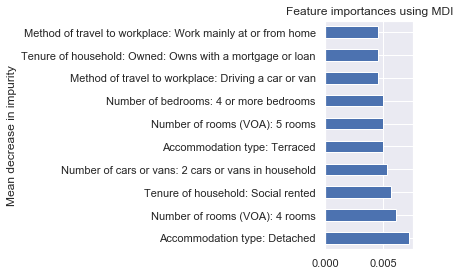

The CV Score for the training data is 0.863%, and for the test data it is 0.740%
Accuracy: 0.865


In [61]:
# Init the param grid and the model
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ["auto", "ball_tree", "kd_tree", "brute"],
    'leaf_size': [10, 20, 30, 40, 50,],
    'p': [1, 2, 3]
}
knnc = KNeighborsClassifier()

# Grid search for best parameters
grid_search = GridSearchCV(estimator=knnc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x2_train, y2_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Generate a new model based on the best parameters
knnc_best = KNeighborsClassifier(**best_params)
knnc_best.fit(x2_train, y2_train)

importances = permutation_importance(knnc_best, x2_test, y2_test)
indices = importances.importances_mean.argsort()[::-1]

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]
top_features_importance = importances.importances_mean[top_features_indices]

# Create a Series for the top feature importances
knnc_importances = pd.Series(top_features_importance, index=top_features)

# Plot the importances with error bars
fig, ax = plt.subplots()
knnc_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Select the top features from the DataFrame
x2_train_top = x2_train[top_features]
x2_test_top = x2_test[top_features]

# Train the model with top features
knnc_top = KNeighborsClassifier(**best_params)
knnc = knnc_top.fit(x2_train_top, y2_train)

# Cross validate the accuracy
accuracyKNNC_train = cross_val_score(estimator=knnc, X = x2_train_top, y = y2_train, cv=5)
accuracyKNNC_test = cross_val_score(estimator=knnc, X = x2_test_top, y = y2_test, cv=5)
print("The CV Score for the training data is %.3f%%, and for the test data it is %.3f%%" %(accuracyKNNC_train.mean(), accuracyKNNC_test.mean()))

# Calculate the predictive accuracy
knnc_predictions = knnc.predict(x2_test_top)
print("Accuracy:", round(accuracy_score(y2_test,knnc_predictions), 3))



## 3.5 K-Nearest Neighbour - Regressor
----- UN-USED -----

In [62]:
"""param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ["auto", "ball_tree", "kd_tree", "brute"],
    'leaf_size': [10, 20, 30, 40, 50,],
    'p': [1, 2, 3]
}
knnr = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=knnr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x1_train, y1_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
knnr_best = KNeighborsRegressor(**best_params)
knnr_best.fit(x1_train, y1_train)
knnr_best.score(x1_train,y1_train)
predictions = knnr_best.predict(x1_train)
knnr_best.score(x1_test,y1_test)
accuracyRFM = cross_val_score(estimator=knnr_best, X = x1_train, y = y1_train, cv=5)
accuracyRFM.mean()
knnr_predictions = knnr_best.predict(x1_test)
knnr_predictions
columns = y1_test.columns
colours = ['b','r','orange','cyan','olivedrab','springgreen','pink']
plt.figure(figsize=(20,14))
for idx, col in enumerate(columns):
    ax = sns.regplot(x=y1_test[col], y=knnr_predictions[:,idx], ci=50, line_kws={'color':'purple'},label=col, color=colours[idx])
    mean_prediction = knnr_predictions[:, idx].mean()
    mean_test = y1_test[col].mean()
    ax.scatter(mean_test,mean_prediction, color='k',s=300, marker='o')
    ax.scatter(mean_test,mean_prediction, color=colours[idx],s=200, marker='o')
    # Calculate regression metrics
    mse = mean_squared_error(y1_test[col], knnr_predictions[:,idx])
    mae = mean_absolute_error(y1_test[col], knnr_predictions[:,idx])
    r2 = r2_score(y1_test[col], knnr_predictions[:,idx])
    print(col,": Mean Squared Error (MSE):", round(mse, 2))
    print(col,": Mean Absolute Error (MAE):", round(mae, 2))
    print(col,": R² Score:", round(r2, 2))
ax.legend()
ax.set(xlabel='Actual Values', ylabel='Predicted Values')
ax.set_title('K Nearest Neighbour Predictions')
knnr_predictions_trans = []
for row in knnr_predictions:
    knnr_predictions_trans.append(columns[np.argmax(row)])
print(knnr_predictions_trans)"""

'param_grid = {\n    \'n_neighbors\': [3, 5, 7, 10, 15, 20],\n    \'weights\': [\'uniform\', \'distance\'],\n    \'algorithm\': ["auto", "ball_tree", "kd_tree", "brute"],\n    \'leaf_size\': [10, 20, 30, 40, 50,],\n    \'p\': [1, 2, 3]\n}\nknnr = KNeighborsRegressor()\ngrid_search = GridSearchCV(estimator=knnr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)\ngrid_search.fit(x1_train, y1_train)\nbest_params = grid_search.best_params_\nprint("Best parameters found: ", best_params)\nknnr_best = KNeighborsRegressor(**best_params)\nknnr_best.fit(x1_train, y1_train)\nknnr_best.score(x1_train,y1_train)\npredictions = knnr_best.predict(x1_train)\nknnr_best.score(x1_test,y1_test)\naccuracyRFM = cross_val_score(estimator=knnr_best, X = x1_train, y = y1_train, cv=5)\naccuracyRFM.mean()\nknnr_predictions = knnr_best.predict(x1_test)\nknnr_predictions\ncolumns = y1_test.columns\ncolours = [\'b\',\'r\',\'orange\',\'cyan\',\'olivedrab\',\'springgreen\',\'pink\']\nplt.figure(figsize=(20,14))\nfor 

## 3.6 Naive-Bayes Gaussian

In [64]:
gnb = GaussianNB()  # Initial NB

# Search for best parameters
grid_search = GridSearchCV(estimator=gnb, param_grid={'var_smoothing': np.logspace(0, -20, num=200)}, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x2_train, y2_train)
#grid_search.fit(x2_train_scaled, y2_train.ravel())
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get a new NB based on the best parameters
gnb_best = GaussianNB(**best_params)
gnb_best.fit(x2_train, y2_train)  

"""importances = permutation_importance(gnb_best, x2_test, y2_test)
indices = importances.importances_mean.argsort()[::-1]

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]
top_features_importance = importances.importances_mean[top_features_indices]

# Create a Series for the top feature importances
gnb_importances = pd.Series(top_features_importance, index=top_features)

# Plot the importances with error bars
fig, ax = plt.subplots()
gnb_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Select the top features from the DataFrame
x2_train_top = x2_train[top_features]
x2_test_top = x2_test[top_features]

# Train the model with top features
gnb_top = GaussianNB(**best_params)
gnb = gnb_top.fit(x2_train_top, y2_train)
""" # Accuracy: 0.492 - With Feature Matching Above

# Cross validate the score.
accuracyGNB_train = cross_val_score(estimator=gnb_best, X = x2_train, y = y2_train, cv=5)
accuracyGNB_test = cross_val_score(estimator=gnb_best, X = x2_test, y = y2_test, cv=5)
print("The CV Score for the training data is %.3f%%, and for the test data it is %.3f%%" %(accuracyGNB_train.mean(), accuracyGNB_test.mean()))

# Calculate the predictive accuracy
gnb_predictions = gnb_best.predict(x2_test)
print("Accuracy:", round(accuracy_score(y2_test,gnb_predictions), 3))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


Best parameters found:  {'var_smoothing': 8.907354638610422e-11}
The CV Score for the training data is 0.734%, and for the test data it is 0.723%
Accuracy: 0.748


## 3.7 Support Vector Classifier (SVC)

In [65]:
# Init the param grid and the model
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}
svc = SVC(random_state=random_code,  probability=True)

# Grid search for best parameters
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x2_train, y2_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Generate a new model based on the best parameters
svc_best = SVC(**best_params, random_state=random_code, probability=True)
svc_best.fit(x2_train, y2_train)

"""importances = permutation_importance(svc_best, x2_test, y2_test)
indices = importances.importances_mean.argsort()[::-1]

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]
top_features_importance = importances.importances_mean[top_features_indices]

# Create a Series for the top feature importances
svc_importances = pd.Series(top_features_importance, index=top_features)

# Plot the importances with error bars
fig, ax = plt.subplots()
svc_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Assuming 'importances' and 'indices' are already defined
top_features_indices = indices[:10]  # Adjust the number of top features as needed
top_features = x2_train.columns[top_features_indices]

# Select the top features from the DataFrame
x2_train_top = x2_train[top_features]
x2_test_top = x2_test[top_features]

# Train the model with top features
svc_top = SVC(**best_params, random_state=random_code, probability=True)
svc = svc_top.fit(x2_train_top, y2_train)
""" # Accuracy: 0.609 - With Feature Matching Above

# Cross validate the accuracy
accuracySVC_train = cross_val_score(estimator=svc_best, X = x2_train, y = y2_train, cv=5)
accuracySVC_test = cross_val_score(estimator=svc_best, X = x2_test, y = y2_test, cv=5)
print("The CV Score for the training data is %.3f%%, and for the test data it is %.3f%%" %(accuracySVC_train.mean(), accuracySVC_test.mean()))

# Calculate the predictive accuracy
svc_predictions = svc_best.predict(x2_test)
print("Accuracy:", round(accuracy_score(y2_test,svc_predictions), 3))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   24.5s finished


Best parameters found:  {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
The CV Score for the training data is 0.773%, and for the test data it is 0.697%
Accuracy: 0.76


# 4.0 Ensemble Models
Let's vote and see what happens.

In [66]:
#ensemble_model = VotingClassifier(estimators=[('rfr', rfr), ('knnr', knnr_best)], voting='soft')

In [67]:
ensemble_model = VotingClassifier(estimators=[('rfc', rfc), ('tree', tree), ('knnc', knnc_best), ('gnb', gnb_best), ('svc', svc_best)], voting='soft')

ensemble_model.fit(x2_train, y2_train)
ensemble_predictions = ensemble_model.predict(x2_test)
print("Ensemble model score: ", ensemble_model.score(x2_test, y2_test))
print("Accuracy:", round(accuracy_score(y2_test,ensemble_predictions), 3))

Ensemble model score:  0.9083969465648855
Accuracy: 0.908


In [68]:
mapped_ensemble_predictions = [num_to_party_map[letter] for letter in ensemble_predictions]
mapped_y2_test = [num_to_party_map[letter] for letter in y2_test]
result = pd.DataFrame({'Truth': mapped_y2_test, 'Prediction': mapped_ensemble_predictions}, columns=['Truth', 'Prediction'])
result['Match'] = result['Truth'] == result['Prediction']
result.to_csv(os.path.join('CensusElection_PredictorV2.csv'), index=False)

# Conclusion

So what are my thoughts:
1. SMOTE is definitly a necessity, the improvement from V1 to V2 can be **almost solely** be attributed to SMOTE's introduction. Which has lead to the model getting a lot better.
2. Removing my regressors. I wanted these in here but I think spending time trying to fit the regressors in here is a lot more work when the corresponding classifier is already present.
3. The addition of the SCV and the GaussianNB are nice but I do not think they are strong contributors currently
    - GaussianNB has gotten stuck into the Welsh language too much (as evidenced by the feature importance. It may be worth just binning these) and has a poor accuracy score to go with it.
    - The feature importances seems to have actually hindered the performance of some of these models, perhaps the code I am using is not thorough enough? I always selected the top 10 so maybe it is better to select more? I could try and find a method to hunt for this.
4. Splitting the datasets into the NatPop, SPIRH, EEO and Housing was a good idea. Perhaps if we pursue this further, and train 4 groups of models? 
    - This would be 4 KNNs, 4 RFCs, 4 GNBs, 4 SVCs and 4 Decision Trees. One for each of the above sets.
    - This would hopefully stop some features dominating (such as Welsh Language ability) in the GNB.
    - The accuracy has gone down actually since I merged the 4 datasets, where Housing even got accuracy up to 92%. Perhaps method with some more voting could be better.
5. I could definitly get some improvements in a V3.
    - Definitly try splitting the models into the aforementioned 4 versions of each model.
    - Add **XGBoosts** into the code to help optimise the code more 
    - See if I can get an iteration working for the regressors, that would be great for additional voting. Although may be better to use models distinct from already exisitng ones (we already have a KNN classifer and a Decision Tree classifer, maybe some more distinct verisons)
    - Get a **CNN** in this? Maybe not worth it but hey, this is my practice Notebook, **I can** paint the walls whatever colour **I want**.
    - Definitly some hypothesis testing too. Maybe some t-testing and some confidence intervals. Basically some actual good tests to get in this.